# Compare Diffusion Metrics and TPSO in MDD and Healthy Controls

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import linear_model
from scipy.stats import spearmanr, mannwhitneyu
import seaborn as sns
from statannotations.Annotator import Annotator

%matplotlib inline
sns.set_theme(style="ticks", color_codes=True)


## Data Preparation and Cleaning

### Demographics

To avoid duplicate data, we will keep the demographics table separate. We will dummy code sex for use in calculations later.

In [2]:
#changing subject_list will no longer cause the code to crash
# subject_list = ['Exp0661_TSPO', 'Exp0666_TSPO', 'Exp0693_TSPO', 'Exp0683_TSPO', 'Exp0704_TSPO', 'Exp0710_TSPO']
subject_list = ['Exp0661_TSPO', 'Exp0666_TSPO', 'Exp0693_TSPO', 'Exp0683_TSPO', 'Exp0704_TSPO', 'Exp0710_TSPO', 
               'Exp0677_TSPOnot', 'Exp0671_TSPOnot']

#map subjects to values
cohort = {'Exp0661_TSPO':'HC', 'Exp0666_TSPO':'HC', 'Exp0693_TSPO':'HC', 'Exp0683_TSPO':'MDD', 'Exp0704_TSPO':'MDD', 
          'Exp0710_TSPO':'MDD', 'Exp0677_TSPOnot':'HC', 'Exp0671_TSPOnot':'HC'}
age = {'Exp0661_TSPO':26, 'Exp0666_TSPO':37, 'Exp0693_TSPO':48, 'Exp0683_TSPO':32, 'Exp0704_TSPO':59, 
       'Exp0710_TSPO':20, 'Exp0677_TSPOnot':22, 'Exp0671_TSPOnot':26}
bmi = {'Exp0661_TSPO':29.1, 'Exp0666_TSPO':21.6, 'Exp0693_TSPO':27.5, 'Exp0683_TSPO':30.5, 
       'Exp0704_TSPO':30.0, 'Exp0710_TSPO':29.3, 'Exp0677_TSPOnot':26.4, 'Exp0671_TSPOnot':24.4}
sex = {'Exp0661_TSPO':'female', 'Exp0666_TSPO':'female', 'Exp0693_TSPO':'male', 'Exp0683_TSPO':'female', 
       'Exp0704_TSPO':'male', 'Exp0710_TSPO':'male', 'Exp0677_TSPOnot':'female', 'Exp0671_TSPOnot':'male'}

#create demographics dataframe
demographics = pd.DataFrame()
demographics['subject'] = subject_list
demographics['cohort'] = demographics['subject'].map(cohort)
demographics['age'] = demographics['subject'].map(age)
demographics['bmi'] = demographics['subject'].map(bmi)
demographics['sex'] = demographics['subject'].map(sex)

#convert cohort and sex to category type
demographics[['cohort', 'sex']]  = demographics[['cohort', 'sex']].astype('category')
#create dummy variables for sex
demographics = pd.get_dummies(demographics, columns=['sex'], prefix='', prefix_sep='', dtype='float64')

demographics


,subject,cohort,age,bmi,female,male
0,Exp0661_TSPO,HC,26,29.1,1.0,0.0
1,Exp0666_TSPO,HC,37,21.6,1.0,0.0
2,Exp0693_TSPO,HC,48,27.5,0.0,1.0
3,Exp0683_TSPO,MDD,32,30.5,1.0,0.0
4,Exp0704_TSPO,MDD,59,30.0,0.0,1.0
5,Exp0710_TSPO,MDD,20,29.3,0.0,1.0
6,Exp0677_TSPOnot,HC,22,26.4,1.0,0.0
7,Exp0671_TSPOnot,HC,26,24.4,0.0,1.0


### Cognition and Affect Data

We need to connect the cognition and affect data from RedCap to the scan data for analysis. We also need to scale the MoCA Blind (`moca_total_v2`) scores so we can compare them to `moca_total`. Per the [official MoCA website](https://www.mocatest.org/faq/#:~:text=The%20test%20may%20be%20scored,considered%20in%20the%20normal%20range.), this is done by multiplying the MoCA Blind score by 30/22. However, note that this score conversion has not been validated.

In [3]:
#import csv downloaded from RedCap report "Affect and Cognition Total Scores"
cog_affect = pd.read_csv('total_affect_cog_scores.csv')

#map subject IDs and cohort
id_key = {'Scanned_1002_VL':'Exp0666_TSPO', 'Scanned_1038_AL':'Exp0693_TSPO', 'Scanned_1037_AL':'Exp0683_TSPO', 
          'Scanned_1059_AL':'Exp0704_TSPO', 'Scanned_1065_AL':'Exp0710_TSPO', 'Scanned_1007_VL':'Exp0677_TSPOnot',
         'Scanned_1017_VL':'Exp0671_TSPOnot'}
cog_affect['subject'] = cog_affect['record_id'].map(id_key)
cog_affect['cohort'] = cog_affect['subject'].map(cohort)

#rename columns
cog_affect.rename(columns={'record_id':'redcap_id', 'score':'madrs_score'}, inplace=True)

#scale MoCA Blind and combine MoCA scores into one column
#if there are scores in both MoCA columns, keep the score in moca_total and discard the MoCA Blind score
cog_affect['moca_total_v2'] = cog_affect['moca_total_v2'] * (30/22)
cog_affect['moca_total'].fillna(cog_affect['moca_total_v2'], inplace=True)
cog_affect['moca_total'] = round(cog_affect['moca_total']) #only whole numbers are valid MoCA scores

#clean up unneeded columns and rows with no subject name
cog_affect = cog_affect[cog_affect['subject'].notna()].drop(columns=['redcap_event_name', 'moca_total_v2'])

#fill in NaN madrs_score as 0
cog_affect['madrs_score'].fillna(0, inplace=True)

cog_affect

,redcap_id,hama_totalscore,madrs_score,moca_total,subject,cohort
1,Scanned_1002_VL,0,0.0,27.0,Exp0666_TSPO,HC
2,Scanned_1007_VL,1,2.0,28.0,Exp0677_TSPOnot,HC
3,Scanned_1017_VL,2,2.0,28.0,Exp0671_TSPOnot,HC
4,Scanned_1037_AL,35,23.0,30.0,Exp0683_TSPO,MDD
5,Scanned_1038_AL,11,9.0,30.0,Exp0693_TSPO,HC
6,Scanned_1059_AL,16,35.0,26.0,Exp0704_TSPO,MDD
7,Scanned_1065_AL,12,28.0,27.0,Exp0710_TSPO,MDD


### Imaging Data

The data is currently in the following format:

- Each subject has 3 tables, one for each statistic: table_mean, table_std, and table_nvox
- Within in each table, each parameter (ie ODI) has a column and each ROI (ie left amygdala) has a row
- The ROIs we ultimately want are spread across multiple rows
    
The following code manipulates the data such that:

* The weighted average and pooled standard deviation of each parameter is calculated for each desired ROI
* Each subject-roi combination has one row
* Each column represents a unique combination of parameter and statistic with the naming convention `parameter_statistic`


In [4]:
#lists are in regex format
#roi_list = ['frontal', 'cingulate', 'Hippocampus', 'FX', 'Cerebellum', 'Amygdala']
roi_list = ['frontal', 'cingulate', 'FX', 
#             'Cerebellum',
           '(nucleus|amygdaloid).*(_haT1T2$)', 
           '(subiculum|CA1|CA3|CA4|HATA|fimbria|HP_tail|hippocampal_fissure|GC-ML|molecular).*(_haT1T2$)']
# param_list = ['TEDdI_DTI_md', 'TEDdI_DTI_fa', 'TEDdI_DTI_ad', 'TEDdI_DTI_rd', 'TEDdI_FWEDTI.md', 'TEDdI_FWEDTI.fa',
#               'TSPOdyn_SUVR.LOC.PET', 'TSPOdyn_SUVR.PET', 'TEDdI_DT2Wfull_vg','TEDdI_DT2Wfull_vw', 'fsoma', 'ODI', 
#               'TEDdI_FWDTI_BallTensor_r1_w_ball.w', 'TEDdI_DKI_mk', 'TEDdI_DKI_awf', 'TEDdI_DKI_ak', 'TEDdI_DKI_rk']
param_list = ['TEDdI_fa','TEDdI_adc','TEDdI_l1','TEDdI_rd','TEDdI_T2','TEDdI_rdsi.fa0','TEDdI_rdsi.fa1',
              'TEDdI_T2DTI_fa','TEDdI_T2DTI_md','TEDdI_T2DTI_ad','TEDdI_T2DTI_rd','TEDdI_T2DTI_t2',
              'TEDdI_T2DKI_fa','TEDdI_T2DKI_md','TEDdI_T2DKI_ad','TEDdI_T2DKI_rd','TEDdI_T2DKI_t2',
              'TEDdI_T2DKI_mk','TEDdI_T2DKI_ak','TEDdI_T2DKI_rk','TEDdI_T2DKI_awf',
              'TEDdI_DTI_fa','TEDdI_DTI_md','TEDdI_DTI_ad','TEDdI_DTI_rd',
              'TEDdI_DKI_fa','TEDdI_DKI_md','TEDdI_DKI_ad','TEDdI_DKI_rd',
              'TEDdI_DKI_mk','TEDdI_DKI_ak','TEDdI_DKI_rk','TEDdI_DKI_awf',
              'TEDdI_Zeta_T2a',
              'TEDdI_DT2W_ad','TEDdI_DT2W_r2','TEDdI_DT2W_rd','TEDdI_DT2W_T2e',
              'TEDdI_DT2W_T2g','TEDdI_DT2W_ve','TEDdI_DT2W_vg','TEDdI_DT2W_vw','TEDdI_DT2W_wd',
              'TEDdI_DT2Wfull_adi','TEDdI_DT2Wfull_ade','TEDdI_DT2Wfull_rd','TEDdI_DT2Wfull_T2e','TEDdI_DT2Wfull_T2g',
              'TEDdI_DT2Wfull_ve','TEDdI_DT2Wfull_vg','TEDdI_DT2Wfull_vw','TEDdI_DT2Wfull_vi','TEDdI_DT2Wfull_T2i',
              'TEDdI_DT2Wmdt_DT2W_r1_S0.s0',
              'TEDdI_DT2Wmdt_DT2W_r1_StickT2.d','TEDdI_DT2Wmdt_DT2W_r1_StickT2.T2','TEDdI_DT2Wmdt_DT2W_r1_w_stickT2.w',
              'TEDdI_DT2Wmdt_DT2W_r1_ZeppelinT2.d','TEDdI_DT2Wmdt_DT2W_r1_ZeppelinT2.dperp0',
              'TEDdI_DT2Wmdt_DT2W_r1_ZeppelinT2.T2','TEDdI_DT2Wmdt_DT2W_r1_ZeppelinT2.theta',
              'TEDdI_DT2Wmdt_DT2W_r1_ZeppelinT2.phi','TEDdI_DT2Wmdt_DT2W_r1_w_zeppelinT2.w',
              'TEDdI_DT2Wmdt_DT2W_r1_DotT2.T2','TEDdI_DT2Wmdt_DT2W_r1_w_dotT2.w',
              'TEDdI_DT2Wmdt_DT2W_r1_w_ballT2.w',
              'TEDdI_NODDI_NODDI_S0.s0','TEDdI_NODDI_NODDI_NODDI_IC.kappa','TEDdI_NODDI_NODDI_w_ic.w',
              'TEDdI_NODDI_NODDI_NODDI_EC.dperp0','TEDdI_NODDI_NODDI_NODDI_EC.kappa','TEDdI_NODDI_NODDI_w_ec.w',
              'TEDdI_NODDI_NODDI_w_csf.w','TEDdI_NODDI_NODDI_NDI','TEDdI_NODDI_NODDI_ODI',
              'TEDdI_FWDTI_BallTensor_r1_S0.s0',
              'TEDdI_FWDTI_BallTensor_r1_Tensor0.MD','TEDdI_FWDTI_BallTensor_r1_Tensor0.FA',
              'TEDdI_FWDTI_BallTensor_r1_Tensor0.AD','TEDdI_FWDTI_BallTensor_r1_Tensor0.RD',
              'TEDdI_FWDTI_BallTensor_r1_w_tensor0.w',
              'TEDdI_FWDTI_BallTensor_r1_w_ball.w',
              'TEDdI_FWEDTI.md','TEDdI_FWEDTI.ad','TEDdI_FWEDTI.rd','TEDdI_FWEDTI.fa','TEDdI_FWEDTI.f',
              'MGE_T2star','MTR_MTR','MGE_QSM_MEDI',
              'TSPO_data','TSPOdyn_SUVR.PET','TSPOdyn_SUVR.LOC.PET',
              'TEDdI_SANDI_AMICO_SANDI_FIT_fsoma', 'TEDdI_SANDI_AMICO_SANDI_FIT_De', 'TEDdI_SANDI_AMICO_SANDI_FIT_Din',
              'TEDdI_SANDI_AMICO_SANDI_FIT_fextra','TEDdI_SANDI_AMICO_SANDI_FIT_fneurite'
             ]
subfields_list = ['ctx-lh-caudalmiddlefrontal', 'ctx-rh-caudalmiddlefrontal',
                'ctx-lh-frontalpole', 'ctx-rh-frontalpole',
                'ctx-lh-lateralorbitofrontal', 'ctx-rh-lateralorbitofrontal',
                'ctx-lh-medialorbitofrontal', 'ctx-rh-medialorbitofrontal',
                'ctx-lh-rostralmiddlefrontal', 'ctx-rh-rostralmiddlefrontal',
                'ctx-lh-superiorfrontal', 'ctx-rh-superiorfrontal',
                'ctx-lh-caudalanteriorcingulate', 'ctx-rh-caudalanteriorcingulate',
                'ctx-lh-isthmuscingulate', 'ctx-rh-isthmuscingulate',
                'ctx-lh-posteriorcingulate', 'ctx-rh-posteriorcingulate',
                'ctx-lh-rostralanteriorcingulate', 'ctx-rh-rostralanteriorcingulate',
                'FX_left', 'FX_right',
                'Left-Cerebellum-Cortex', 'Right-Cerebellum-Cortex',
                'Left-Cerebellum-White-Matter', 'Right-Cerebellum-White-Matter',
                'lh-hippocampal_fissure', 'rh-hippocampal_fissure',
                'lh-Accessory-Basal-nucleus_haT1T2', 'rh-Accessory-Basal-nucleus_haT1T2',
                'lh-Basal-nucleus_haT1T2', 'rh-Basal-nucleus_haT1T2',
                'lh-Central-nucleus_haT1T2', 'rh-Central-nucleus_haT1T2',
                'lh-Cortical-nucleus_haT1T2', 'rh-Cortical-nucleus_haT1T2',
                'lh-Lateral-nucleus_haT1T2', 'rh-Lateral-nucleus_haT1T2',
                'lh-Medial-nucleus_haT1T2', 'rh-Medial-nucleus_haT1T2',
                'lh-Paralaminar-nucleus_haT1T2', 'rh-Paralaminar-nucleus_haT1T2',
                'lh-Anterior-amygdaloid-area-AAA_haT1T2', 'rh-Anterior-amygdaloid-area-AAA_haT1T2',
                'lh-Corticoamygdaloid-transitio_haT1T2', 'rh-Corticoamygdaloid-transitio_haT1T2',
                'lh-parasubiculum_haT1T2', 'rh-parasubiculum_haT1T2',
                'lh-presubiculum-body_haT1T2', 'rh-presubiculum-body_haT1T2',
                'lh-presubiculum-head_haT1T2', 'rh-presubiculum-head_haT1T2',
                'lh-subiculum-body_haT1T2', 'rh-subiculum-body_haT1T2',
                'lh-subiculum-head_haT1T2', 'rh-subiculum-head_haT1T2',
                'lh-CA1-body_haT1T2', 'rh-CA1-body_haT1T2',
                'lh-CA1-head_haT1T2', 'rh-CA1-head_haT1T2',
                'lh-CA3-body_haT1T2', 'rh-CA3-body_haT1T2',
                'lh-CA3-head_haT1T2', 'rh-CA3-head_haT1T2',
                'lh-CA4-body_haT1T2', 'rh-CA4-body_haT1T2',
                'lh-CA4-head_haT1T2', 'rh-CA4-head_haT1T2',
                'lh-GC-ML-DG-body_haT1T2', 'rh-GC-ML-DG-body_haT1T2',
                'lh-GC-ML-DG-head_haT1T2', 'rh-GC-ML-DG-head_haT1T2',
                'lh-molecular_layer_HP-body_haT1T2', 'rh-molecular_layer_HP-body_haT1T2',
                'lh-molecular_layer_HP-head_haT1T2', 'rh-molecular_layer_HP-head_haT1T2',
                'lh-HATA_haT1T2', 'rh-HATA_haT1T2',
                'lh-fimbria_haT1T2', 'rh-fimbria_haT1T2',
                'lh-HP_tail_haT1T2', 'rh-HP_tail_haT1T2',
            '(^lh-).*(subiculum|CA1|CA3|CA4|HATA|fimbria|HP_tail|hippocampal_fissure|GC-ML|molecular).*(_haT1T2$)',
            '(^rh-).*(subiculum|CA1|CA3|CA4|HATA|fimbria|HP_tail|hippocampal_fissure|GC-ML|molecular).*(_haT1T2$)',
                '(^lh-).*(nucleus|amygdaloid).*(_haT1T2$)', 
                '(^rh-).*(nucleus|amygdaloid).*(_haT1T2$)',
                '(^lh-).*(parasubiculum|head|HATA).*(_haT1T2$)',
                '(^rh-).*(parasubiculum|head|HATA).*(_haT1T2$)',
                '(^lh-).*(body|fimbria).*(_haT1T2$)',
                '(^rh-).*(body|fimbria).*(_haT1T2$)',
                '(^ctx-lh-).*(frontal)', '(^ctx-rh-).*(frontal)',
                '(^ctx-lh-).*(cingulate)', '(^ctx-rh-).*(cingulate)'
                 ]


In [5]:
#function for calculating pooled standard deviations
def pooled_std(df, column_std, column_nvox):
    denominator = sum(df[column_nvox])-len(df[column_nvox])
    if denominator != 0:
        pooled_std = np.sqrt(sum((df[column_std]**2) * (df[column_nvox]-1)) / (sum(df[column_nvox])-len(df[column_nvox])))
        return pooled_std


In [6]:
#function for creating TSPO_stats dataframe
def create_stats_df(subject_list, roi_list, param_list, cohort_dict):
    
    TSPO_stats = pd.DataFrame()

    #loop through subjects in subject_list
    for subj in subject_list:
        #read in means table
        csv_mean = 'ROIvals_' + subj + '_table_mean.csv'
        table_mean = pd.read_csv(csv_mean, index_col=0)
        table_mean = table_mean.add_suffix('_mean')

        #read in standard deviations table
        csv_std = 'ROIvals_' + subj + '_table_std.csv'
        table_std = pd.read_csv(csv_std, index_col=0)
        table_std = table_std.add_suffix('_std')

        #read in number of voxels table
        csv_nvox = 'ROIvals_' + subj + '_table_nvox.csv'
        table_nvox = pd.read_csv(csv_nvox, index_col=0)
        table_nvox = table_nvox.add_suffix('_nvox')

        #create temporary subj_stats dataframe
        subj_stats = pd.DataFrame()

        #loop through ROIs
        for roi in roi_list:
            #select rows we want to include in our composite ROI
            #more complex ROIs should be in regex format
            table_mean_roi = table_mean.filter(regex=roi, axis=0)
            table_std_roi = table_std.filter(regex=roi, axis=0)
            table_nvox_roi = table_nvox.filter(regex=roi, axis=0)
            #add prefix identifying roi to each column name
            prefix_str = roi + "_"
            table_mean_roi = table_mean_roi.add_prefix(prefix_str)
            table_std_roi = table_std_roi.add_prefix(prefix_str)
            table_nvox_roi = table_nvox_roi.add_prefix(prefix_str)

            #initialize dictonaries of ROI averages, standard deviations, and voxel sums
            roi_averages = {}
            roi_stds = {}
            roi_vox_sums = {}

            #loop through parameters (ie SUVR, FA)
            for param in param_list:
                #find the column that corresponds with the desired parameter in each table
                table_mean_param = table_mean_roi.filter(like=param, axis=1)
                table_std_param = table_std_roi.filter(like=param, axis=1)
                table_nvox_param = table_nvox_roi.filter(like=param, axis=1)

                #combine parameter columns from each table
                param_stats = pd.concat([table_mean_param, table_std_param, table_nvox_param], axis=1)
                if len(param_stats.index) > 0:

                    #pull out columns for means, standard deviations, and voxel sums
                    column_mean = list([col for col in param_stats.columns if 'mean' in col])
                    if len(column_mean) > 0:
                        column_mean = column_mean[0]

                    column_std = list([col for col in param_stats.columns if 'std' in col])
                    if len (column_std) > 0:
                        column_std = column_std[0]

                    column_nvox = list([col for col in param_stats.columns if 'nvox' in col])
                    if len(column_nvox) > 0:
                        column_nvox = column_nvox[0]

                    #calculate weighted average and append to roi_averages dictionary
                    weighted_average = np.average(param_stats[column_mean], weights=param_stats[column_nvox], axis=0)
                    column_mean_str = param + "_mean"
                    roi_averages[column_mean_str] = weighted_average

                    #calculate pooled standard deviation and append to roi_stds dictionary
                    param_pooled_std = pooled_std(param_stats, column_std, column_nvox)            
                    column_std_str = param + "_std"
                    roi_stds[column_std_str] = param_pooled_std

                    #calculate voxel sums and append to roi_vox_sums dictionary
                    nvox = sum(param_stats[column_nvox])
                    column_nvox_str = param + "_nvox"
                    roi_vox_sums[column_nvox_str] = nvox

            #combine averages, standard deviations, and voxel sums dictionaries into one roi_stats dictionary
            roi_stats = {**roi_averages, **roi_stds, **roi_vox_sums}
            #convert roi_stats into a numeric dataframe
            roi_stats = pd.DataFrame(data=pd.Series(roi_stats, dtype='object')).transpose().apply(pd.to_numeric)
            #add a column that specifies the name of the ROI
            roi_stats['ROI'] = roi
            #append roi_stats to subj_stats
            subj_stats = pd.concat([subj_stats, roi_stats], axis=0)

        #add a column that specifies the subject id
        subj_stats['subject'] = subj
        #append subj_stats to TSPO_stats
        TSPO_stats = pd.concat([TSPO_stats, subj_stats], axis=0)
    #add cohorts
    TSPO_stats['cohort'] = TSPO_stats['subject'].map(cohort_dict)
    return TSPO_stats

In [7]:
#create TSPO_stats
TSPO_stats = create_stats_df(subject_list, roi_list, param_list, cohort)
#rename composite ROIs
TSPO_stats.replace({'(nucleus|amygdaloid).*(_haT1T2$)':'amygdala', 
                    '(subiculum|CA1|CA3|CA4|HATA|fimbria|HP_tail|hippocampal_fissure|GC-ML|molecular).*(_haT1T2$)'\
                    :'hippocampus'}, 
                   inplace=True)
roi_list = ['amygdala' if x == '(nucleus|amygdaloid).*(_haT1T2$)' else x for x in roi_list]
roi_list = ['hippocampus' if x == \
            '(subiculum|CA1|CA3|CA4|HATA|fimbria|HP_tail|hippocampal_fissure|GC-ML|molecular).*(_haT1T2$)' \
            else x for x in roi_list]
#print first 5 rows
TSPO_stats


,TEDdI_fa_mean,TEDdI_adc_mean,TEDdI_l1_mean,TEDdI_rd_mean,TEDdI_T2_mean,TEDdI_rdsi.fa0_mean,TEDdI_rdsi.fa1_mean,TEDdI_T2DTI_fa_mean,TEDdI_T2DTI_md_mean,TEDdI_T2DTI_ad_mean,...,TSPOdyn_SUVR.PET_nvox,TSPOdyn_SUVR.LOC.PET_nvox,TEDdI_SANDI_AMICO_SANDI_FIT_fsoma_nvox,TEDdI_SANDI_AMICO_SANDI_FIT_De_nvox,TEDdI_SANDI_AMICO_SANDI_FIT_Din_nvox,TEDdI_SANDI_AMICO_SANDI_FIT_fextra_nvox,TEDdI_SANDI_AMICO_SANDI_FIT_fneurite_nvox,ROI,subject,cohort
0,0.138287,0.001018,0.001141,0.000956,0.112013,0.238354,0.119458,0.122999,0.900582,1.000104,...,113464,113464,113464,113346,101338,113464,113464,frontal,Exp0661_TSPO,HC
0,0.155227,0.000851,0.000972,0.000789,0.106366,0.283171,0.123941,0.140808,0.788090,0.896688,...,19306,19306,19306,19306,14083,19306,17124,cingulate,Exp0661_TSPO,HC
0,0.295274,0.002013,0.002609,0.001715,0.098541,0.567230,0.095968,0.325301,1.332458,1.764915,...,2112,2112,2112,2112,1474,2112,2112,FX,Exp0661_TSPO,HC
0,0.223332,0.000857,0.001064,0.000763,0.097905,0.356369,0.103353,0.204733,0.783325,0.958417,...,3305,3305,3305,3248,3166,3305,3305,amygdala,Exp0661_TSPO,HC
0,0.218931,0.000962,0.001187,0.000852,0.113578,0.353012,0.125039,0.203662,0.810440,0.998296,...,6298,6298,6299,6283,5248,6299,6074,hippocampus,Exp0661_TSPO,HC
0,0.120037,0.001081,0.001190,0.001026,0.132589,0.325189,0.222995,0.109544,0.919447,1.009423,...,129595,129595,129595,129595,107224,129595,126366,frontal,Exp0666_TSPO,HC
0,0.146912,0.000917,0.001043,0.000853,0.121081,0.362870,0.221890,0.135531,0.795908,0.901397,...,20067,20067,20067,20067,13629,20067,15236,cingulate,Exp0666_TSPO,HC
0,0.338522,0.002180,0.002935,0.001803,0.127634,0.689037,0.000000,0.380055,1.165308,1.656088,...,2610,2610,2610,2506,1627,2610,2214,FX,Exp0666_TSPO,HC
0,0.231567,0.000853,0.001076,0.000760,0.098676,0.427986,0.207584,0.213272,0.730815,0.896261,...,3517,3517,3517,3368,3481,3517,3515,amygdala,Exp0666_TSPO,HC
0,0.186343,0.000973,0.001173,0.000875,0.110242,0.360159,0.179594,0.179072,0.780299,0.931813,...,6781,6781,6781,6731,5954,6781,6779,hippocampus,Exp0666_TSPO,HC


In [8]:
#create TSPO_subfields_stats
TSPO_subfields_stats = create_stats_df(subject_list, subfields_list, param_list, cohort)


In [9]:
TSPO_subfields_stats.replace({'(^lh-).*(nucleus|amygdaloid).*(_haT1T2$)':'lh-amygdala', 
                '(^rh-).*(nucleus|amygdaloid).*(_haT1T2$)':'rh-amygdala',
                '(^lh-).*(parasubiculum|head|HATA).*(_haT1T2$)':'lh-HP_head',
                '(^rh-).*(parasubiculum|head|HATA).*(_haT1T2$)':'rh-HP_head',
                '(^lh-).*(body|fimbria).*(_haT1T2$)':'lh-HP_body',
                '(^rh-).*(body|fimbria).*(_haT1T2$)':'rh-HP_body',
                '(^lh-).*(subiculum|CA1|CA3|CA4|HATA|fimbria|HP_tail|hippocampal_fissure|GC-ML|molecular).*(_haT1T2$)'\
                              :'lh-hippocampus',
                '(^rh-).*(subiculum|CA1|CA3|CA4|HATA|fimbria|HP_tail|hippocampal_fissure|GC-ML|molecular).*(_haT1T2$)'\
                              :'rh-hippocampus',
                '(^ctx-lh-).*(frontal)':'lh-frontal',
                '(^ctx-rh-).*(frontal)':'rh-frontal',
                '(^ctx-lh-).*(cingulate)':'lh-cingulate',
                '(^ctx-rh-).*(cingulate)':'rh-cingulate'},
                inplace=True)
subfields_list = ['lh-amygdala' if x == '(^lh-).*(nucleus|amygdaloid).*(_haT1T2$)' else x for x in subfields_list]
subfields_list = ['rh-amygdala' if x == '(^rh-).*(nucleus|amygdaloid).*(_haT1T2$)' else x for x in subfields_list]
subfields_list = ['lh-HP_head' if x == '(^lh-).*(parasubiculum|head|HATA).*(_haT1T2$)' else x for x in subfields_list]
subfields_list = ['rh-HP_head' if x == '(^rh-).*(parasubiculum|head|HATA).*(_haT1T2$)' else x for x in subfields_list]
subfields_list = ['lh-HP_body' if x == '(^lh-).*(body|fimbria).*(_haT1T2$)' else x for x in subfields_list]
subfields_list = ['rh-HP_body' if x == '(^rh-).*(body|fimbria).*(_haT1T2$)' else x for x in subfields_list]
subfields_list = ['lh-hippocampus' if x == \
                  '(^lh-).*(subiculum|CA1|CA3|CA4|HATA|fimbria|HP_tail|hippocampal_fissure|GC-ML|molecular).*(_haT1T2$)'\
                  else x for x in subfields_list]
subfields_list = ['rh-hippocampus' if x == \
                  '(^rh-).*(subiculum|CA1|CA3|CA4|HATA|fimbria|HP_tail|hippocampal_fissure|GC-ML|molecular).*(_haT1T2$)'\
                  else x for x in subfields_list]
subfields_list = ['lh-frontal' if x == '(^ctx-lh-).*(frontal)' else x for x in subfields_list]
subfields_list = ['rh-frontal' if x == '(^ctx-rh-).*(frontal)' else x for x in subfields_list]
subfields_list = ['lh-cingulate' if x == '(^ctx-lh-).*(cingulate)' else x for x in subfields_list]
subfields_list = ['rh-cingulate' if x == '(^ctx-rh-).*(cingulate)' else x for x in subfields_list]

TSPO_subfields_stats

,TEDdI_fa_mean,TEDdI_adc_mean,TEDdI_l1_mean,TEDdI_rd_mean,TEDdI_T2_mean,TEDdI_rdsi.fa0_mean,TEDdI_rdsi.fa1_mean,TEDdI_T2DTI_fa_mean,TEDdI_T2DTI_md_mean,TEDdI_T2DTI_ad_mean,...,TSPOdyn_SUVR.PET_nvox,TSPOdyn_SUVR.LOC.PET_nvox,TEDdI_SANDI_AMICO_SANDI_FIT_fsoma_nvox,TEDdI_SANDI_AMICO_SANDI_FIT_De_nvox,TEDdI_SANDI_AMICO_SANDI_FIT_Din_nvox,TEDdI_SANDI_AMICO_SANDI_FIT_fextra_nvox,TEDdI_SANDI_AMICO_SANDI_FIT_fneurite_nvox,ROI,subject,cohort
0,0.142668,0.001147,0.001277,0.001082,0.126570,0.247282,0.120012,0.128619,0.990210,1.096614,...,6315.0,6315.0,6315.0,6315.0,4981.0,6315.0,6315.0,ctx-lh-caudalmiddlefrontal,Exp0661_TSPO,HC
0,0.131476,0.001139,0.001271,0.001073,0.126954,0.230854,0.110438,0.116121,0.936607,1.031964,...,7110.0,7110.0,7110.0,7110.0,6028.0,7110.0,7110.0,ctx-rh-caudalmiddlefrontal,Exp0661_TSPO,HC
0,0.138290,0.000952,0.001073,0.000891,0.091839,0.195730,0.119491,0.114983,0.861581,0.955699,...,1258.0,1258.0,1258.0,1258.0,1258.0,1258.0,1258.0,ctx-lh-frontalpole,Exp0661_TSPO,HC
0,0.109143,0.000883,0.000976,0.000837,0.093187,0.183631,0.103651,0.097878,0.825354,0.905081,...,1328.0,1328.0,1328.0,1328.0,1328.0,1328.0,1328.0,ctx-rh-frontalpole,Exp0661_TSPO,HC
0,0.176992,0.000732,0.000863,0.000668,0.087828,0.273341,0.129050,0.156620,0.734278,0.850834,...,6754.0,6754.0,6754.0,6726.0,6597.0,6754.0,6754.0,ctx-lh-lateralorbitofrontal,Exp0661_TSPO,HC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.315907,0.000928,0.001250,0.000772,0.122352,0.487058,0.131590,0.284370,0.724144,0.960044,...,0.0,0.0,1217.0,1217.0,981.0,1217.0,1111.0,rh-HP_body,Exp0671_TSPOnot,HC
0,0.130786,0.001104,0.001226,0.001042,0.130066,0.308115,0.143734,0.118633,0.946553,1.045261,...,0.0,0.0,60074.0,60074.0,47589.0,60074.0,60074.0,lh-frontal,Exp0671_TSPOnot,HC
0,0.142726,0.001059,0.001186,0.000995,0.129829,0.319108,0.144684,0.131761,0.903077,1.008973,...,0.0,0.0,62186.0,62186.0,49012.0,62186.0,62186.0,rh-frontal,Exp0671_TSPOnot,HC
0,0.126124,0.000950,0.001066,0.000893,0.119544,0.297125,0.160235,0.115837,0.798496,0.892426,...,0.0,0.0,11400.0,11400.0,8564.0,11400.0,9483.0,lh-cingulate,Exp0671_TSPOnot,HC


In [10]:
#define subfields lists (replaces roi_list when calling functions)
hippo_list = [
    'lh-hippocampus', 'rh-hippocampus',
    'lh-HP_head', 'rh-HP_head',
              'lh-HP_body', 'rh-HP_body',
              'lh-hippocampal_fissure', 'rh-hippocampal_fissure',
              'lh-HP_tail_haT1T2', 'rh-HP_tail_haT1T2',
              'lh-parasubiculum_haT1T2', 'rh-parasubiculum_haT1T2',
              'lh-presubiculum-body_haT1T2', 'rh-presubiculum-body_haT1T2',
              'lh-presubiculum-head_haT1T2', 'rh-presubiculum-head_haT1T2',
              'lh-subiculum-body_haT1T2', 'rh-subiculum-body_haT1T2',
              'lh-subiculum-head_haT1T2', 'rh-subiculum-head_haT1T2',
              'lh-CA1-body_haT1T2', 'rh-CA1-body_haT1T2',
              'lh-CA1-head_haT1T2', 'rh-CA1-head_haT1T2',
              'lh-CA3-head_haT1T2', 'rh-CA3-head_haT1T2',
              'lh-CA3-body_haT1T2', 'rh-CA3-body_haT1T2',
              'lh-CA4-body_haT1T2', 'rh-CA4-body_haT1T2',
              'lh-CA4-head_haT1T2', 'rh-CA4-head_haT1T2',
              'lh-GC-ML-DG-body_haT1T2', 'rh-GC-ML-DG-body_haT1T2',
              'lh-GC-ML-DG-head_haT1T2', 'rh-GC-ML-DG-head_haT1T2',
              'lh-molecular_layer_HP-body_haT1T2', 'rh-molecular_layer_HP-body_haT1T2',
              'lh-molecular_layer_HP-head_haT1T2', 'rh-molecular_layer_HP-head_haT1T2',
              'lh-HATA_haT1T2', 'rh-HATA_haT1T2',
              'lh-fimbria_haT1T2', 'rh-fimbria_haT1T2']
hippo_list_short = ['lh-hippocampus', 'rh-hippocampus', 'lh-HP_head', 'rh-HP_head', 'lh-HP_body', 'rh-HP_body',
              'lh-hippocampal_fissure', 'rh-hippocampal_fissure',
              'lh-HP_tail_haT1T2', 'rh-HP_tail_haT1T2',]
amy_list = [
    'lh-amygdala', 'rh-amygdala',
            'lh-Accessory-Basal-nucleus_haT1T2', 'rh-Accessory-Basal-nucleus_haT1T2',
            'lh-Basal-nucleus_haT1T2', 'rh-Basal-nucleus_haT1T2',
            'lh-Central-nucleus_haT1T2', 'rh-Central-nucleus_haT1T2',
            'lh-Cortical-nucleus_haT1T2', 'rh-Cortical-nucleus_haT1T2',
            'lh-Lateral-nucleus_haT1T2', 'rh-Lateral-nucleus_haT1T2',
            'lh-Medial-nucleus_haT1T2', 'rh-Medial-nucleus_haT1T2',
            'lh-Paralaminar-nucleus_haT1T2', 'rh-Paralaminar-nucleus_haT1T2',
            'lh-Anterior-amygdaloid-area-AAA_haT1T2', 'rh-Anterior-amygdaloid-area-AAA_haT1T2',
            'lh-Corticoamygdaloid-transitio_haT1T2', 'rh-Corticoamygdaloid-transitio_haT1T2']
amy_list_short = ['lh-amygdala', 'rh-amygdala']
cb_list = ['Left-Cerebellum-Cortex', 'Right-Cerebellum-Cortex',
           'Left-Cerebellum-White-Matter', 'Right-Cerebellum-White-Matter']
frontal_list = [
    'lh-frontal', 'rh-frontal',
                'ctx-lh-caudalmiddlefrontal', 'ctx-rh-caudalmiddlefrontal',
                'ctx-lh-frontalpole', 'ctx-rh-frontalpole',
                'ctx-lh-lateralorbitofrontal', 'ctx-rh-lateralorbitofrontal',
                'ctx-lh-medialorbitofrontal', 'ctx-rh-medialorbitofrontal',
                'ctx-lh-rostralmiddlefrontal', 'ctx-rh-rostralmiddlefrontal',
                'ctx-lh-superiorfrontal', 'ctx-rh-superiorfrontal']
frontal_list_short = ['lh-frontal', 'rh-frontal']
cingulate_list = [
    'lh-cingulate', 'rh-cingulate',
                  'ctx-lh-caudalanteriorcingulate', 'ctx-rh-caudalanteriorcingulate',
                  'ctx-lh-isthmuscingulate', 'ctx-rh-isthmuscingulate',
                  'ctx-lh-posteriorcingulate', 'ctx-rh-posteriorcingulate',
                  'ctx-lh-rostralanteriorcingulate', 'ctx-rh-rostralanteriorcingulate']
cingulate_list_short = ['lh-cingulate', 'rh-cingulate']
fx_list = ['FX_left', 'FX_right']

## Group Statistics

Now that data preparation is complete, we are ready to calculate group statistics for MDD vs controls. 

### Demographics

Calculate the mean age and counts of each sex per cohort. Then, check if the demographics values are significantly different between cohorts.

In [11]:
means = demographics.groupby('cohort')[['age','bmi']].mean().add_suffix('_mean')
stds = demographics.groupby('cohort')[['age','bmi']].std().add_suffix('_std')
sex_sums = demographics.groupby('cohort')[['female','male']].sum()
group_demos = pd.concat([means, stds, sex_sums], axis=1)
group_demos = group_demos.reindex(sorted(group_demos.columns), axis=1)

group_demos

,age_mean,age_std,bmi_mean,bmi_std,female,male
cohort,,,,,,
HC,31.8,10.639549,25.800000,2.904307,3.0,2.0
MDD,37.0,19.974984,29.933333,0.602771,1.0,2.0


In [12]:
#check if demographics values are significantly different between cohorts
demo_list = ['age', 'bmi', 'female', 'male']
MDD = demographics[demographics['cohort'] == 'MDD']
HC = demographics[demographics['cohort'] == 'HC']

for demo in demo_list:
    print(demo + " " + str(mannwhitneyu(MDD[demo], HC[demo])))

age MannwhitneyuResult(statistic=7.0, pvalue=0.5)
bmi MannwhitneyuResult(statistic=0.0, pvalue=0.018444212853524936)
female MannwhitneyuResult(statistic=5.5, pvalue=0.3042039001164992)
male MannwhitneyuResult(statistic=5.5, pvalue=0.3042039001164992)


BMI is significantly higher in depressed participants.

### Cognition and Affect Scores

For each cohort, calculate the means and standard deviations for the Hama Hamilton Anxiety Rating Scale, Madrs Montgomery Asberg Depression Rating Scale, and MoCA Montreal Cognitive Assessment. Then, check if the scores are significantly different between cohorts.

In [13]:
score_list = ['hama_totalscore', 'madrs_score', 'moca_total']
means = cog_affect.groupby('cohort')[score_list].mean().add_suffix('_mean')
stds = cog_affect.groupby('cohort')[score_list].std().add_suffix('_std')
group_scores = pd.concat([means, stds], axis=1)
group_scores = group_scores.reindex(sorted(group_scores.columns), axis=1)

group_scores

,hama_totalscore_mean,hama_totalscore_std,madrs_score_mean,madrs_score_std,moca_total_mean,moca_total_std
cohort,,,,,,
HC,3.5,5.066228,3.250000,3.947573,28.250000,1.258306
MDD,21.0,12.288206,28.666667,6.027714,27.666667,2.081666


In [14]:
MDD = cog_affect[cog_affect['cohort'] == 'MDD']
HC = cog_affect[cog_affect['cohort'] == 'HC']

for score in score_list:
    MDD = MDD[MDD[score].notna()]
    HC = HC[HC[score].notna()]
    print(score + " " + str(mannwhitneyu(MDD[score], HC[score])))

hama_totalscore MannwhitneyuResult(statistic=0.0, pvalue=0.02591496360895484)
madrs_score MannwhitneyuResult(statistic=0.0, pvalue=0.024872995360751497)
moca_total MannwhitneyuResult(statistic=4.0, pvalue=0.2928310795229547)


Hama Anxiety and Madrs Depression scores differ significantly between cohorts, with depressed participants scoring higher in both. MoCA Cognition scores do not differ significantly between cohorts.

### Imaging Data

Each imaging parameter has a mean column, an std column, and an nvox column. For each parameter and within each cohort, we will average the mean column and sum the nvox column using `groupby`. Then, we will use the new total nvox and the `pooled_std` function defined above to calculate the voxel-wise standard deviations for each parameter. Finally, we will again use `groupby` to calculate the subject-wise standard deviations for each parameter and within each cohort. 

Cohen's D between cohorts, based on the voxel-wise standard deviations and then the subject-wise standard deviations, are then calculated for each ROI and each parameter.

Statistical difference is checked as part of the figures below.

In [15]:
#create function for group stats for imaging data
def group_stats(TSPO_stats):
    #select columns to average
    mean_cols = TSPO_stats.columns[(TSPO_stats.columns.str.contains('mean'))].tolist()
    #select columns to sum
    sum_cols = TSPO_stats.columns[(TSPO_stats.columns.str.contains('nvox'))].tolist()

    TSPO_stats_group_means = TSPO_stats.groupby(['cohort', 'ROI'])[mean_cols].mean()
    TSPO_stats_group_sums = TSPO_stats.groupby(['cohort', 'ROI'])[sum_cols].sum()
    
    #use the mean_cols list defined above to calculate subject-wise standard deviations
    TSPO_subject_stds = TSPO_stats.groupby(['cohort', 'ROI'])[mean_cols].std().add_suffix("_subject_std")
    #append subject-wise standard deviations to TSPO_stats_group
    TSPO_stats_group = pd.concat([TSPO_stats_group_means, TSPO_stats_group_sums, TSPO_subject_stds], axis=1)
    
    return TSPO_stats_group

In [16]:
#create a function that adds voxel-wise stds to the group stats
def voxel_wise_stds(TSPO_stats, roi_list, param_list):

    #list columns needed for calculated pooled standard deviations
    std_cols = TSPO_stats.columns[TSPO_stats.columns.str.contains('std|nvox|ROI|cohort|subject')].tolist()
    #list cohorts
    cohort_list = ['HC', 'MDD']
    #initialize voxel-wise pooled standard deviations dataframe
    pooled_stds = pd.DataFrame()

    #loop through cohorts
    for cohort in cohort_list:
        #pull necessary columns and rows from TSPO_stats
        stds_cohort = TSPO_stats[TSPO_stats['cohort'] == cohort][std_cols]

        #create temporary pooled_stds_cohort dataframe
        pooled_stds_cohort = pd.DataFrame()

        #loop through each roi
        for roi in roi_list:
            #pull rows for that ROI from stds_cohort
            stds_cohort_roi = stds_cohort[stds_cohort['ROI'] == roi]
            
            #initialize temporary pooled_stds_cohort_roi dictionary
            pooled_stds_cohort_roi = {}

            for param in param_list:
                #for each parameter, pull the standard deviation and voxel sums into stds_cohort_roi_param
                column_std_str = param + "_std"
                column_nvox_str = param + "_nvox"
                #drop rows where std = NA
                stds_cohort_roi = stds_cohort_roi[stds_cohort_roi[column_std_str].notna()]
                stds_cohort_roi_param = stds_cohort_roi[[column_std_str, column_nvox_str]]

                #calculate pooled standard deviation and append to pooled_stds_cohort_roi dictionary
                pooled_std_cohort_roi_param = pooled_std(stds_cohort_roi_param, column_std_str, column_nvox_str)
                pooled_stds_cohort_roi[column_std_str] = pooled_std_cohort_roi_param

            #convert pooled_stds_cohort_roi to a dataframe
            pooled_stds_cohort_roi = pd.DataFrame(pd.Series(pooled_stds_cohort_roi)).transpose().apply(pd.to_numeric)
            #add column naming ROI
            pooled_stds_cohort_roi['ROI'] = roi
            #append pooled_stds_cohort_roi to pooled_stds_cohort
            pooled_stds_cohort = pd.concat([pooled_stds_cohort, pooled_stds_cohort_roi], axis=0)

        #add column naming cohort
        pooled_stds_cohort['cohort'] = cohort

        #append pooled_stds_cohort to pooled_stds
        pooled_stds = pd.concat([pooled_stds, pooled_stds_cohort], axis=0)

    #set the index of pooled_stds to match the index of TSPO_stats_group
    ind = pd.MultiIndex.from_frame(pooled_stds[['cohort', 'ROI']])
    pooled_stds = pooled_stds.set_index(ind)
    #call group_stats function defined above
    TSPO_stats_group = group_stats(TSPO_stats)
    #append pooled_stds to TSPO_stats_group, and reset the index
    TSPO_stats_group = pd.concat([TSPO_stats_group, pooled_stds], axis=1)
    return TSPO_stats_group.reset_index(drop=True)
    

In [17]:
#create TSPO_stats_group and print first 5 rows
TSPO_stats_group = voxel_wise_stds(TSPO_stats, roi_list, param_list)
TSPO_stats_group

,TEDdI_fa_mean,TEDdI_adc_mean,TEDdI_l1_mean,TEDdI_rd_mean,TEDdI_T2_mean,TEDdI_rdsi.fa0_mean,TEDdI_rdsi.fa1_mean,TEDdI_T2DTI_fa_mean,TEDdI_T2DTI_md_mean,TEDdI_T2DTI_ad_mean,...,TSPO_data_std,TSPOdyn_SUVR.PET_std,TSPOdyn_SUVR.LOC.PET_std,TEDdI_SANDI_AMICO_SANDI_FIT_fsoma_std,TEDdI_SANDI_AMICO_SANDI_FIT_De_std,TEDdI_SANDI_AMICO_SANDI_FIT_Din_std,TEDdI_SANDI_AMICO_SANDI_FIT_fextra_std,TEDdI_SANDI_AMICO_SANDI_FIT_fneurite_std,ROI,cohort
0,0.364498,0.001841,0.002504,0.001510,0.099690,0.740067,0.099158,0.383553,1.171492,1.633929,...,2804.451625,0.246094,0.256142,0.130698,0.406139,0.0,0.152438,0.026408,FX,HC
1,0.217919,0.000856,0.001060,0.000763,0.098890,0.397803,0.147658,0.202331,0.746416,0.909743,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,amygdala,HC
2,0.148792,0.000879,0.001003,0.000818,0.113541,0.307559,0.151426,0.136973,0.778652,0.884927,...,2023.632240,0.141867,0.148591,0.114579,0.352864,0.0,0.119586,0.024543,cingulate,HC
3,0.132557,0.001069,0.001190,0.001009,0.122746,0.271624,0.142400,0.120884,0.915024,1.012006,...,1704.735745,0.134051,0.147457,0.156363,0.433246,0.0,0.161895,0.027082,frontal,HC
4,0.210588,0.000936,0.001152,0.000833,0.114002,0.375066,0.145576,0.198173,0.786456,0.957646,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hippocampus,HC
5,0.372975,0.001852,0.002568,0.001494,0.084657,0.642080,0.000000,0.393586,1.083268,1.540888,...,2034.204856,0.137265,0.136430,0.145129,0.483314,0.0,0.170987,0.030254,FX,MDD
6,0.253881,0.000831,0.001055,0.000725,0.108533,0.430281,0.098150,0.233847,0.734553,0.917077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,amygdala,MDD
7,0.159469,0.000873,0.001007,0.000808,0.113667,0.300005,0.139460,0.146264,0.770873,0.883892,...,1861.877485,0.141803,0.140914,0.115735,0.361758,0.0,0.121434,0.022930,cingulate,MDD
8,0.146391,0.001097,0.001233,0.001030,0.129713,0.268437,0.126546,0.133314,0.910979,1.019267,...,1569.522587,0.124065,0.123408,0.153688,0.440673,0.0,0.162804,0.029031,frontal,MDD
9,0.270437,0.000835,0.001091,0.000712,0.111383,0.444155,0.097547,0.245383,0.761930,0.970314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hippocampus,MDD


In [18]:
#create TSPO_subfield_stats_group and print first 5 rows
TSPO_subfields_stats_group = voxel_wise_stds(TSPO_subfields_stats, subfields_list, param_list)
TSPO_subfields_stats_group.head()

,TEDdI_fa_mean,TEDdI_adc_mean,TEDdI_l1_mean,TEDdI_rd_mean,TEDdI_T2_mean,TEDdI_rdsi.fa0_mean,TEDdI_rdsi.fa1_mean,TEDdI_T2DTI_fa_mean,TEDdI_T2DTI_md_mean,TEDdI_T2DTI_ad_mean,...,TSPO_data_std,TSPOdyn_SUVR.PET_std,TSPOdyn_SUVR.LOC.PET_std,TEDdI_SANDI_AMICO_SANDI_FIT_fsoma_std,TEDdI_SANDI_AMICO_SANDI_FIT_De_std,TEDdI_SANDI_AMICO_SANDI_FIT_Din_std,TEDdI_SANDI_AMICO_SANDI_FIT_fextra_std,TEDdI_SANDI_AMICO_SANDI_FIT_fneurite_std,ROI,cohort
0,0.384433,0.001748,0.002418,0.001413,0.106971,0.766141,0.105131,0.398255,1.118087,1.587856,...,2708.960815,0.235836,0.245506,0.136881,0.447511,0.0,0.159154,0.027929,FX_left,HC
1,0.340208,0.001962,0.002617,0.001634,0.083997,0.706947,0.092161,0.365941,1.236240,1.691404,...,2921.873718,0.258590,0.269099,0.122668,0.347436,0.0,0.143753,0.024251,FX_right,HC
2,0.184077,0.000822,0.000983,0.000741,0.124343,0.356548,0.139767,0.186007,0.673438,0.809022,...,2194.736806,0.191703,0.226313,0.123971,0.481360,0.0,0.148025,0.026724,Left-Cerebellum-Cortex,HC
3,0.335748,0.000541,0.000746,0.000446,0.102509,0.578797,0.205005,0.335877,0.553647,0.763688,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Left-Cerebellum-White-Matter,HC
4,0.188037,0.000827,0.000988,0.000745,0.125274,0.364485,0.148135,0.187531,0.691070,0.827966,...,-0.000000,-0.000000,-0.000000,0.107377,0.427478,0.0,0.127051,0.026580,Right-Cerebellum-Cortex,HC


## Generate Figures



### Correlation Between Anxiety and Depression

Linear Regression is for visualization only.

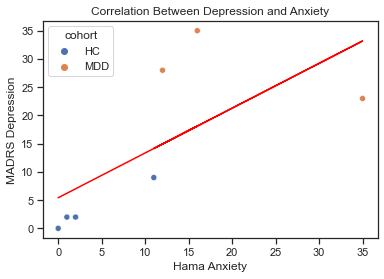

SpearmanrResult(correlation=0.8829187134416479, pvalue=0.008450342381896611)


In [19]:
#pull anxiety and depression scores
x = 'hama_totalscore'
y = 'madrs_score'
affect = cog_affect[[x, y, 'cohort']].copy()
#get rid of rows with NaN scores
affect = affect[(affect[x].notna()) & (affect[y].notna())]
#intantiate, train, and fit a linear model
lr = linear_model.LinearRegression()
lr.fit(affect[[x]], affect[y])
predictions = lr.predict(affect[[x]])
sns.scatterplot(data=affect, x=x, y=y, hue='cohort')
plt.plot(affect[x], predictions, color='red')
plt.ylabel('MADRS Depression')
plt.xlabel('Hama Anxiety')
plt.title('Correlation Between Depression and Anxiety')
plt.show()
print(spearmanr(affect[[x,y]]))

Depression and anxiety are highly correlated. No surprises there.

### Imaging Parameters Between Cohorts



In [21]:
#dictionary of param names vs how they are named on the figures, 
#needed in all imaging chart and significance functions

param_names = {'TEDdI_fa':'MRTrix FA','TEDdI_adc':'MRTrix ADC','TEDdI_l1':'MRTRIX L1','TEDdI_rd':'MRTrix RD',
               'TEDdI_T2':'Diffusion T2','TEDdI_rdsi.fa0':'RDSI FA0','TEDdI_rdsi.fa1':'RDSI FA1',
               'TEDdI_T2DTI_fa':'T2 DTI FA','TEDdI_T2DTI_md':'T2 DTI MD','TEDdI_T2DTI_ad':'T2 DTI AD',
               'TEDdI_T2DTI_rd':'T2 DTI RD','TEDdI_T2DTI_t2':'T2 DTI T2',
               'TEDdI_T2DKI_fa':'T2 DKI FA','TEDdI_T2DKI_md':'T2 DKI MD','TEDdI_T2DKI_ad':'T2 DKI AD',
               'TEDdI_T2DKI_rd':'T2 DKI RD','TEDdI_T2DKI_t2':'T2 DKI T2','TEDdI_T2DKI_mk':'T2 DKI MK',
               'TEDdI_T2DKI_ak':'T2 DKI AK','TEDdI_T2DKI_rk':'T2 DKI RK','TEDdI_T2DKI_awf':'T2 DKI AWF',
               'TEDdI_DTI_fa':'DTI FA','TEDdI_DTI_md':'DTI MD','TEDdI_DTI_ad':'DTI AD','TEDdI_DTI_rd':'DTI RD',
               'TEDdI_DKI_fa':'DKI FA','TEDdI_DKI_md':'DKI MD','TEDdI_DKI_ad':'DKI AD','TEDdI_DKI_rd':'DKI RD',
               'TEDdI_DKI_mk':'DKI MK','TEDdI_DKI_ak':'DKI AK','TEDdI_DKI_rk':'DKI RK','TEDdI_DKI_awf':'DKI AWF',
               'TEDdI_Zeta_T2a':'T2 Zeta',
               'TEDdI_DT2W_ad':'DT2W AD','TEDdI_DT2W_r2':'DT2W R2','TEDdI_DT2W_rd':'DT2W RD',
               'TEDdI_DT2W_T2e':'DT2W T2e','TEDdI_DT2W_T2g':'DT2W T2g','TEDdI_DT2W_ve':'DT2W VE',
               'TEDdI_DT2W_vg':'DT2W VG','TEDdI_DT2W_vw':'DT2W VW','TEDdI_DT2W_wd':'DT2W WD',
               'TEDdI_DT2Wfull_adi':'DT2W full ADI','TEDdI_DT2Wfull_ade': 'DT2W full ADE',
               'TEDdI_DT2Wfull_rd':'DT2W full RD','TEDdI_DT2Wfull_T2e':'DT2W full T2e',
               'TEDdI_DT2Wfull_T2g':'DT2W full T2g','TEDdI_DT2Wfull_ve':'DT2W full VE',
               'TEDdI_DT2Wfull_vg':'DT2W full VG','TEDdI_DT2Wfull_vw':'DT2W full VW','TEDdI_DT2Wfull_vi':'DT2W full VI',
               'TEDdI_DT2Wfull_T2i':'DT2Wfull T2i',
               'TEDdI_DT2Wmdt_DT2W_r1_S0.s0':'DT2W MDT S0','TEDdI_DT2Wmdt_DT2W_r1_StickT2.d':'DT2W MDT StickT2 D',
               'TEDdI_DT2Wmdt_DT2W_r1_StickT2.T2':'DT2W MDT StickT2 T2',
               'TEDdI_DT2Wmdt_DT2W_r1_w_stickT2.w':'DT2W MDT StickT2 W',
               'TEDdI_DT2Wmdt_DT2W_r1_ZeppelinT2.d':'DT2W MDT ZeppelinT2 D',
               'TEDdI_DT2Wmdt_DT2W_r1_ZeppelinT2.dperp0': 'DT2W MDT ZeppelinT2 dperp0',
               'TEDdI_DT2Wmdt_DT2W_r1_ZeppelinT2.T2':'DT2W MDT ZeppelinT2 T2',
               'TEDdI_DT2Wmdt_DT2W_r1_ZeppelinT2.theta':'DT2W MDT ZeppelinT2 Theta',
               'TEDdI_DT2Wmdt_DT2W_r1_ZeppelinT2.phi':'DT2W MDT ZeppelinT2 Phi',
               'TEDdI_DT2Wmdt_DT2W_r1_w_zeppelinT2.w':'DT2W MDT ZeppelinT2 W',
               'TEDdI_DT2Wmdt_DT2W_r1_DotT2.T2':'DT2W MDT DotT2 T2',
               'TEDdI_DT2Wmdt_DT2W_r1_w_dotT2.w':'DT2W MDT DotT2 W',
               'TEDdI_DT2Wmdt_DT2W_r1_w_ballT2.w':'DT2W MDT BallT2 W',
               'TEDdI_NODDI_NODDI_S0.s0':'NODDI S0','TEDdI_NODDI_NODDI_NODDI_IC.kappa':'NODDI IC Kappa',
               'TEDdI_NODDI_NODDI_w_ic.w':'NODDI IC W','TEDdI_NODDI_NODDI_NODDI_EC.dperp0':'NODDI EC dperp0',
               'TEDdI_NODDI_NODDI_NODDI_EC.kappa':'NODDI EC Kappa','TEDdI_NODDI_NODDI_w_ec.w':'NODDI EC W',
               'TEDdI_NODDI_NODDI_w_csf.w':'NODDI CSF','TEDdI_NODDI_NODDI_NDI':'NODDI NDI',
               'TEDdI_NODDI_NODDI_ODI':'NODDI ODI',
               'TEDdI_FWDTI_BallTensor_r1_S0.s0':'FWDTI S0',
               'TEDdI_FWDTI_BallTensor_r1_Tensor0.MD':'FWDTI MD','TEDdI_FWDTI_BallTensor_r1_Tensor0.FA':'FWDTI FA',
               'TEDdI_FWDTI_BallTensor_r1_Tensor0.AD':'FWDTI AD','TEDdI_FWDTI_BallTensor_r1_Tensor0.RD':'FWDTI RD',
               'TEDdI_FWDTI_BallTensor_r1_w_tensor0.w':'FWDTI Tensor0 W',
               'TEDdI_FWDTI_BallTensor_r1_w_ball.w':'FWDTI Ball W',
               'TEDdI_FWEDTI.md':'FWEDTI MD','TEDdI_FWEDTI.ad':'FWEDTI AD','TEDdI_FWEDTI.rd':'FWEDTI RD',
               'TEDdI_FWEDTI.fa':'FWEDTI FA','TEDdI_FWEDTI.f':'FWEDTI F',
               'MGE_T2star':'MGE T2*','MTR_MTR':'MTR','MGE_QSM_MEDI':'MGE QSM MEDI',
               'TSPO_data':'TSPO Data','TSPOdyn_SUVR.PET':'SUVR Whole CB','TSPOdyn_SUVR.LOC.PET':'SUVR LOC',
               'TEDdI_SANDI_AMICO_SANDI_FIT_fsoma':'SANDI fsoma', 'TEDdI_SANDI_AMICO_SANDI_FIT_De':'SANDI EC MD', 
               'TEDdI_SANDI_AMICO_SANDI_FIT_Din':'SANDI Neurite AD', 
               'TEDdI_SANDI_AMICO_SANDI_FIT_fextra':'SANDI fec',
               'TEDdI_SANDI_AMICO_SANDI_FIT_fneurite':'SANDI fneurite'
              }
#list of charts we want (original param names)
# chart_list = ['SUVR', 'TEDdI_DT2Wfull_vg', 
#               'TEDdI_DTI_md', 'TEDdI_DTI_fa', 'TEDdI_FWEDTI.md', 'TEDdI_FWEDTI.fa', 'TEDdI_DT2Wfull_vw', 'fsoma', 
#               'ODI', 'TEDdI_FWDTI_BallTensor_r1_w_ball.w']
# chart_list = ['TSPOdyn_SUVR.LOC.PET']
chart_list = [
#     'TEDdI_DTI_fa', 
#     'TEDdI_DTI_rd', 
#     'TEDdI_DTI_ad', 
#     'TEDdI_DTI_md',
#     'TEDdI_DKI_mk', 
#     'TEDdI_DKI_awf', 
#     'TEDdI_DKI_rk', 
#     'TEDdI_DKI_ak',
#     'TEDdI_DKI_fa', 
#     'TEDdI_DKI_rd', 
#     'TEDdI_DKI_ad', 
#     'TEDdI_DKI_md',
#     'TEDdI_FWEDTI.f',
#     'TEDdI_FWEDTI.fa',
#     'TEDdI_FWEDTI.rd',
#     'TEDdI_FWEDTI.ad',
#     'TEDdI_FWEDTI.md',
    #'TEDdI_FWDTI_BallTensor_r1_Tensor0.FA',
#     'TEDdI_FWDTI_BallTensor_r1_Tensor0.RD',
#     'TEDdI_FWDTI_BallTensor_r1_Tensor0.AD', 
#     'TEDdI_FWDTI_BallTensor_r1_Tensor0.MD'
#     'TEDdI_NODDI_NODDI_S0.s0','TEDdI_NODDI_NODDI_NODDI_IC.kappa','TEDdI_NODDI_NODDI_w_ic.w',
#               'TEDdI_NODDI_NODDI_NODDI_EC.dperp0','TEDdI_NODDI_NODDI_NODDI_EC.kappa','TEDdI_NODDI_NODDI_w_ec.w',
#               'TEDdI_NODDI_NODDI_w_csf.w','TEDdI_NODDI_NODDI_NDI','TEDdI_NODDI_NODDI_ODI', 
    'TEDdI_SANDI_AMICO_SANDI_FIT_fsoma',
    'TEDdI_SANDI_AMICO_SANDI_FIT_De', 
#     'TEDdI_SANDI_AMICO_SANDI_FIT_Din',
    'TEDdI_SANDI_AMICO_SANDI_FIT_fextra',
    'TEDdI_SANDI_AMICO_SANDI_FIT_fneurite'
]
#SANDI fsoma fine, De fine, Din not fine, fextra fine, fneurite not fine for cingulate
# chart_list = ['TEDdI_FWEDTI.md','TEDdI_FWEDTI.ad','TEDdI_FWEDTI.rd','TEDdI_FWEDTI.fa','TEDdI_FWEDTI.f',
#               'TEDdI_DTI_md', 'TEDdI_DTI_fa', 'TEDdI_DTI_rd', 'TEDdI_DTI_ad'    
#               ]

#create a function for generating between cohorts charts
def between_cohorts_chart(TSPO_stats_group, TSPO_stats, chart_list, roi_list, std_suffix):
    MDD = TSPO_stats_group[TSPO_stats_group['cohort'] == 'MDD']
    MDD = MDD[MDD['ROI'].isin(roi_list)]
    HC = TSPO_stats_group[TSPO_stats_group['cohort'] == 'HC']
    HC = HC[HC['ROI'].isin(roi_list)]

    for chart in chart_list:
        mean_str = chart + "_mean"
        std_str = chart + std_suffix
        fig, ax = plt.subplots(figsize=(8,6))
        plt.errorbar(x=MDD['ROI'], y=MDD[mean_str], yerr=MDD[std_str], fmt='Dm')
        plt.errorbar(x=HC['ROI'], y=HC[mean_str], yerr=HC[std_str], fmt='oy')
        plt.ylabel(param_names[chart])
        plt.xticks(rotation=90)
        plt.legend(['MDD', 'HC'])
        plt.title('Mean ' + param_names[chart] + ' per ROI')
        for roi in roi_list:
            MDD_roi = TSPO_stats[(TSPO_stats['ROI'] == roi) & (TSPO_stats['cohort'] == 'MDD')][mean_str]
            HC_roi = TSPO_stats[(TSPO_stats['ROI'] == roi) & (TSPO_stats['cohort'] == 'HC')][mean_str]
            statistic, pvalue = mannwhitneyu(MDD_roi, HC_roi)
            if pvalue < 0.05:
                ax.text(roi, .9, '*', fontsize=16, transform=ax.get_xaxis_transform())
                print(roi + ' ' +str(mannwhitneyu(MDD_roi, HC_roi)))
        plt.show()

In [22]:
def between_cohorts_barchart(TSPO_stats_group, TSPO_stats, chart_list, roi_list):  
    MDD = TSPO_stats_group[TSPO_stats_group['cohort'] == 'MDD']
    MDD = MDD[MDD['ROI'].isin(roi_list)]
    HC = TSPO_stats_group[TSPO_stats_group['cohort'] == 'HC']
    HC = HC[HC['ROI'].isin(roi_list)]

    roi_rows = TSPO_stats[TSPO_stats['ROI'].isin(roi_list)]

    for chart in chart_list:
        mean_str = chart + "_mean"
        std_str = chart + "_std"
        fig, ax = plt.subplots(figsize=(12,8))
    #     plt.errorbar(x=MDD['ROI'], y=MDD[mean_str], yerr=MDD[std_str], fmt='Dm')
    #     plt.errorbar(x=HC['ROI'], y=HC[mean_str], yerr=HC[std_str], fmt='oy')
        ax = sns.barplot(data=roi_rows, x='ROI', y=mean_str, hue='cohort', ci=95)
        plt.ylabel(param_names[chart])
        plt.xticks(rotation=90)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)    
        plt.title('Mean ' + param_names[chart] + ' per ROI')
        for roi, bar in zip(list(roi_rows['ROI'].unique()), ax.patches):
            MDD_roi = TSPO_stats[(TSPO_stats['ROI'] == roi) & (TSPO_stats['cohort'] == 'MDD')][mean_str]
            HC_roi = TSPO_stats[(TSPO_stats['ROI'] == roi) & (TSPO_stats['cohort'] == 'HC')][mean_str]
            statistic, pvalue = mannwhitneyu(MDD_roi, HC_roi)
            if pvalue < 0.05:
                print(roi + ' ' +str(mannwhitneyu(MDD_roi, HC_roi)))
            if pvalue < 0.001:
                ax.text(bar.get_x() + bar.get_width(), 0.95, 
                         '***', ha='center', fontsize=20, transform=ax.get_xaxis_transform())
            elif pvalue < 0.01:
                ax.text(bar.get_x() + bar.get_width(), 0.95, 
                         '**', ha='center', fontsize=20, transform=ax.get_xaxis_transform())
            elif pvalue < 0.05:
                ax.text(bar.get_x() + bar.get_width(), 0.95, 
                         '*', ha='center', fontsize=20, transform=ax.get_xaxis_transform())

        plt.show()

In [23]:
def print_significant_cohort(TSPO_stats, chart_list, roi_list):
    for chart in chart_list:
        mean_str = chart + "_mean"
        for roi in roi_list:
            MDD_roi = TSPO_stats[(TSPO_stats['ROI'] == roi) & (TSPO_stats['cohort'] == 'MDD')][mean_str]
            HC_roi = TSPO_stats[(TSPO_stats['ROI'] == roi) & (TSPO_stats['cohort'] == 'HC')][mean_str]
            statistic, pvalue = mannwhitneyu(MDD_roi, HC_roi)
            if pvalue < 0.05:
               print(param_names[chart], roi) 

#### Voxel-wise Standard deviations

##### Large ROIs
    
- DTI MD
    - ~~Hippocampus~~ not in new ROI
    
- T1 f_W
    - ~~Hippocampus~~ not in new ROI

##### FX Subfields

In [24]:
print_significant_cohort(TSPO_subfields_stats, chart_list, fx_list)

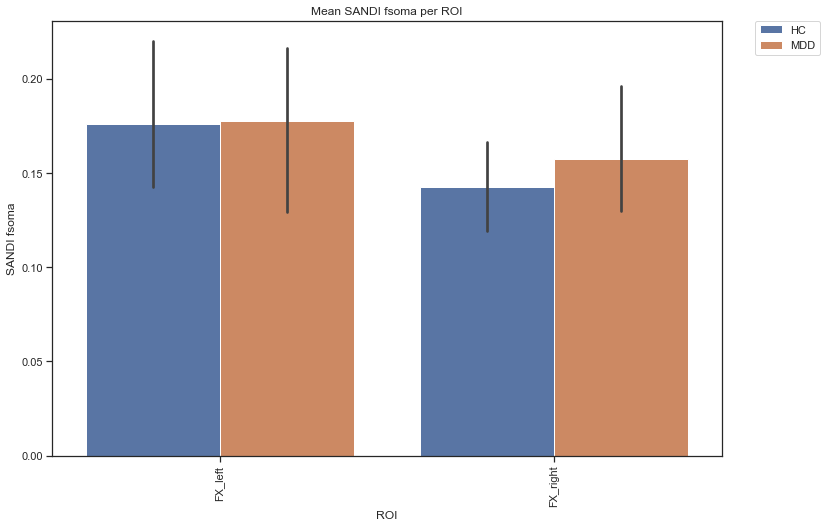

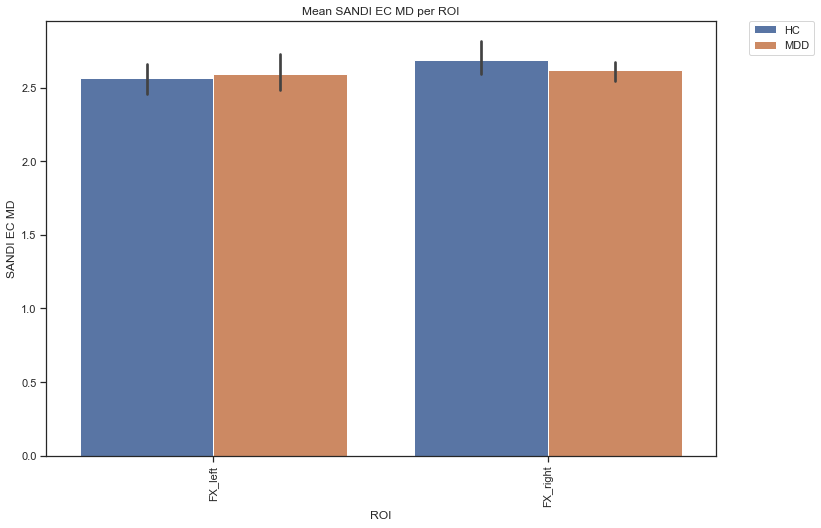

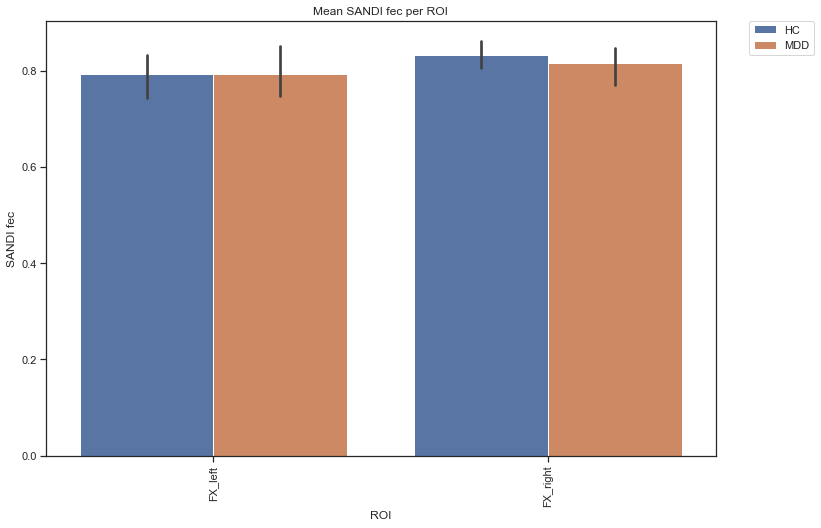

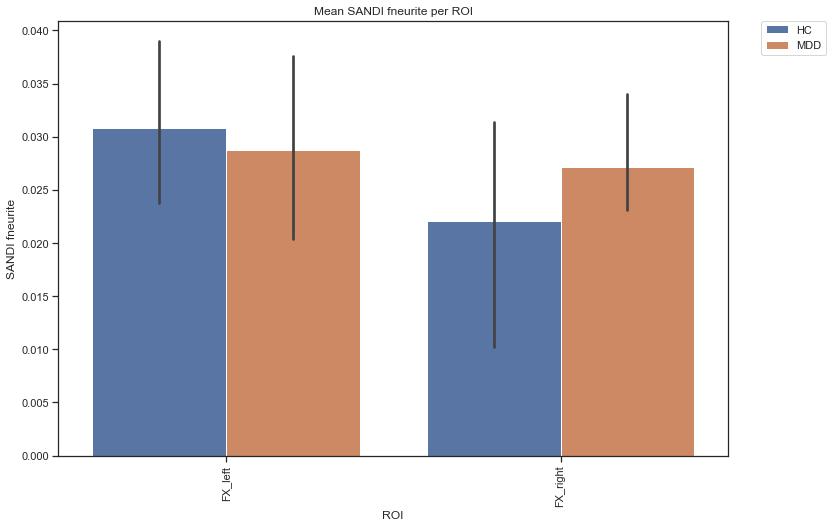

In [25]:
between_cohorts_barchart(TSPO_subfields_stats_group, TSPO_subfields_stats, chart_list, fx_list)

##### Frontal Subfields

In [26]:
print_significant_cohort(TSPO_subfields_stats, chart_list, frontal_list)

SANDI fsoma ctx-rh-medialorbitofrontal
SANDI fneurite ctx-lh-frontalpole
SANDI fneurite ctx-lh-superiorfrontal
SANDI fneurite ctx-rh-superiorfrontal


ctx-rh-medialorbitofrontal MannwhitneyuResult(statistic=1.0, pvalue=0.03681913506015133)


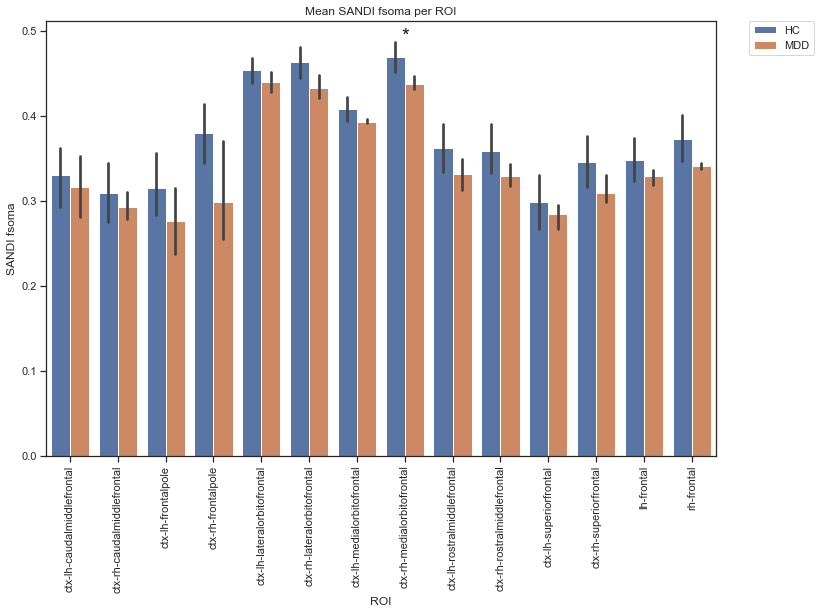

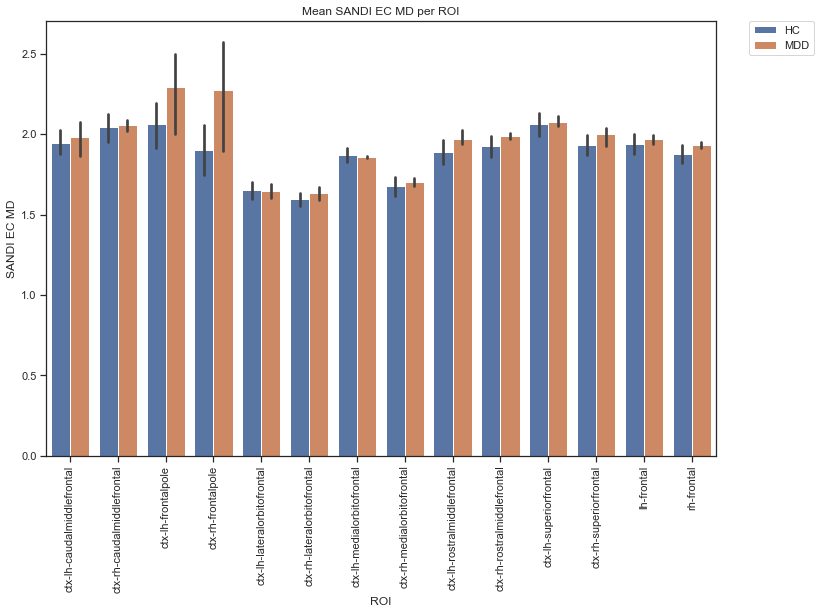

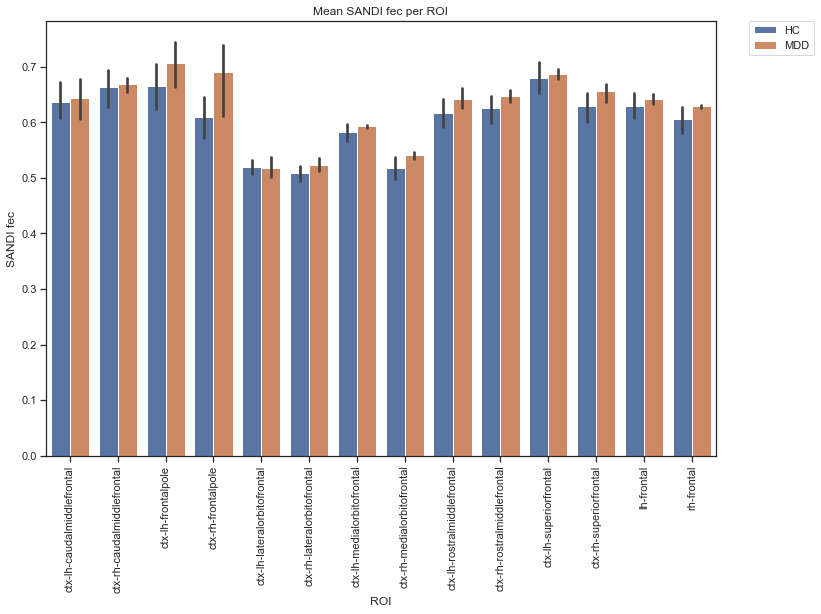

ctx-lh-frontalpole MannwhitneyuResult(statistic=0.0, pvalue=0.018444212853524936)
ctx-lh-superiorfrontal MannwhitneyuResult(statistic=1.0, pvalue=0.03681913506015133)
ctx-rh-superiorfrontal MannwhitneyuResult(statistic=1.0, pvalue=0.03681913506015133)


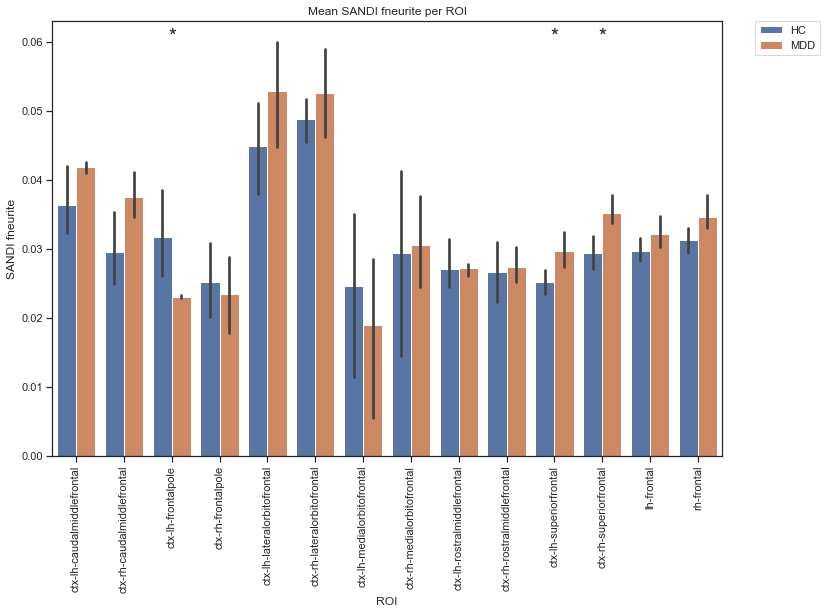

In [27]:
between_cohorts_barchart(TSPO_subfields_stats_group, TSPO_subfields_stats, chart_list, frontal_list)

##### Cingulate Subfields

In [28]:
print_significant_cohort(TSPO_subfields_stats, chart_list, cingulate_list)

ValueError: All numbers are identical in mannwhitneyu

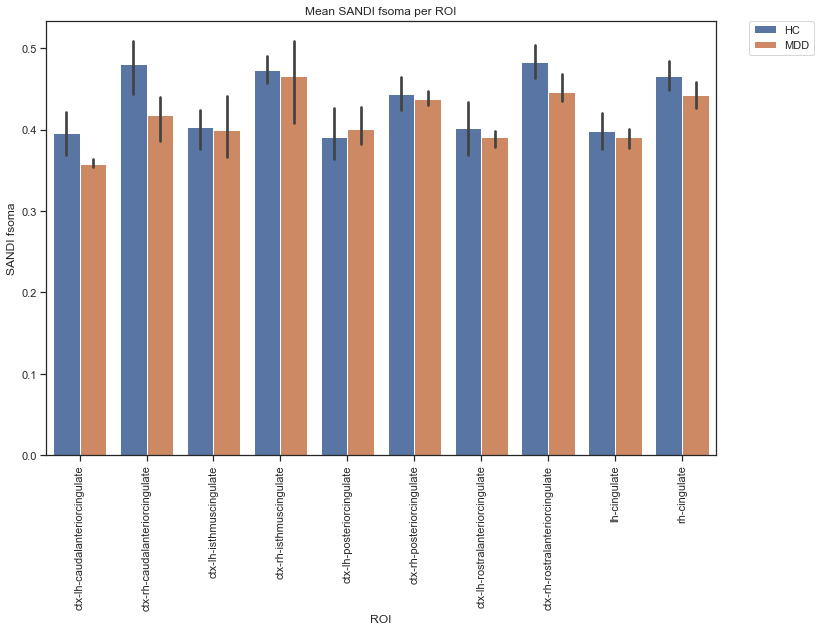

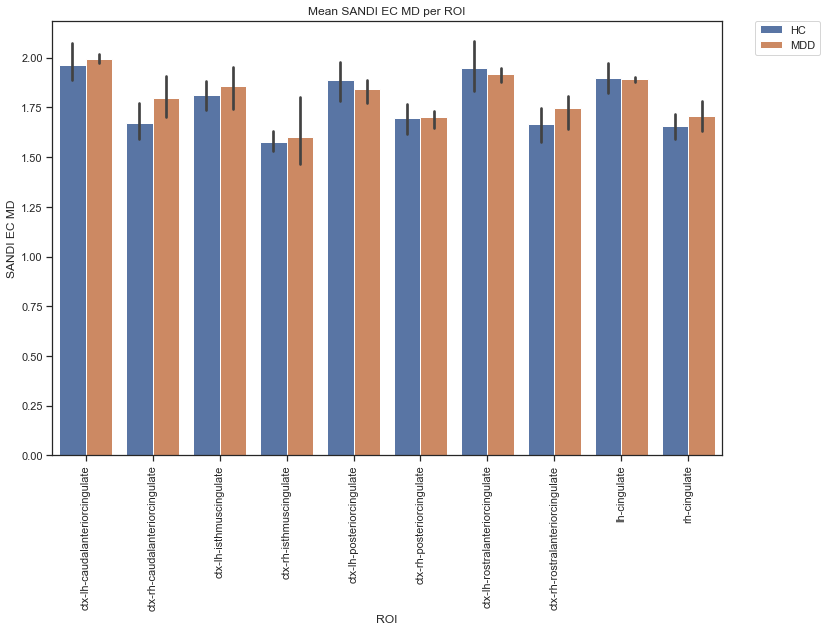

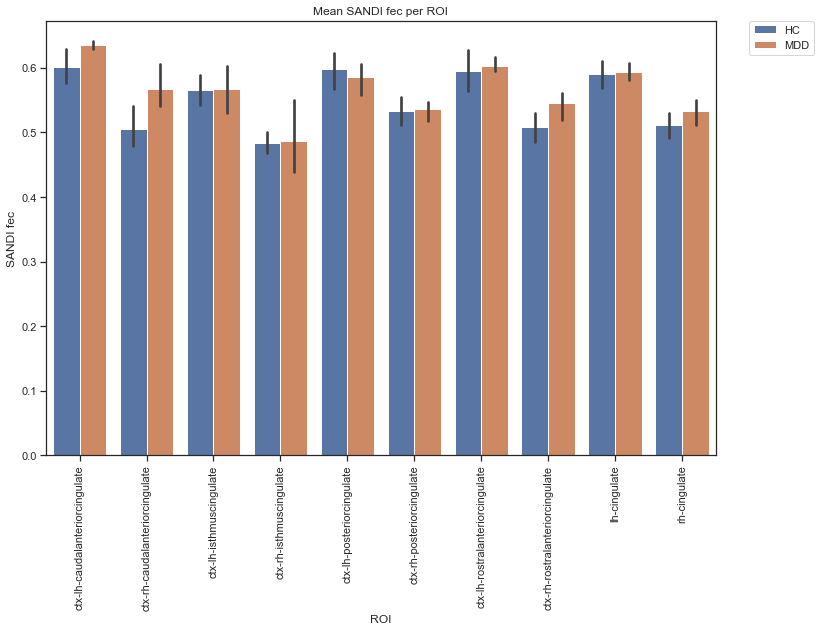

ValueError: All numbers are identical in mannwhitneyu

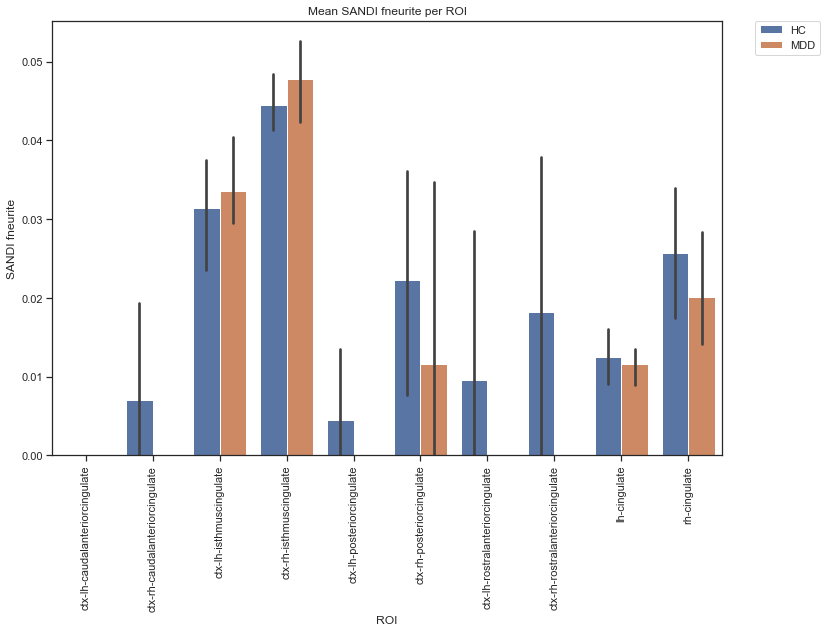

In [29]:
between_cohorts_barchart(TSPO_subfields_stats_group, TSPO_subfields_stats, chart_list, cingulate_list)

##### Hippocampus Subfields

In [31]:
print_significant_cohort(TSPO_subfields_stats, chart_list, hippo_list_short)

SANDI fsoma rh-hippocampus
SANDI fsoma lh-HP_head
SANDI fsoma rh-HP_tail_haT1T2
SANDI EC MD lh-hippocampus
SANDI EC MD rh-hippocampus
SANDI EC MD lh-HP_head
SANDI EC MD rh-HP_body
SANDI EC MD lh-hippocampal_fissure
SANDI EC MD rh-HP_tail_haT1T2
SANDI fec lh-hippocampus
SANDI fec rh-hippocampus
SANDI fec lh-HP_head
SANDI fec rh-hippocampal_fissure
SANDI fec rh-HP_tail_haT1T2
SANDI fneurite lh-HP_head
SANDI fneurite rh-HP_body
SANDI fneurite rh-HP_tail_haT1T2


rh-HP_tail_haT1T2 MannwhitneyuResult(statistic=1.0, pvalue=0.03681913506015133)
rh-hippocampus MannwhitneyuResult(statistic=0.0, pvalue=0.018444212853524936)
lh-HP_head MannwhitneyuResult(statistic=1.0, pvalue=0.03681913506015133)


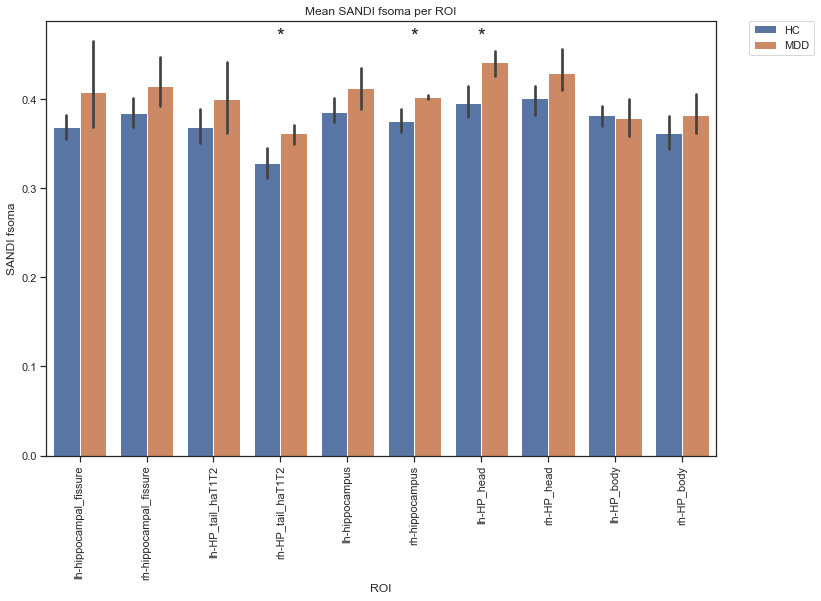

lh-hippocampal_fissure MannwhitneyuResult(statistic=0.0, pvalue=0.018444212853524936)
rh-HP_tail_haT1T2 MannwhitneyuResult(statistic=1.0, pvalue=0.03681913506015133)
lh-hippocampus MannwhitneyuResult(statistic=1.0, pvalue=0.03681913506015133)
rh-hippocampus MannwhitneyuResult(statistic=1.0, pvalue=0.03681913506015133)
lh-HP_head MannwhitneyuResult(statistic=0.0, pvalue=0.018444212853524936)
rh-HP_body MannwhitneyuResult(statistic=1.0, pvalue=0.03681913506015133)


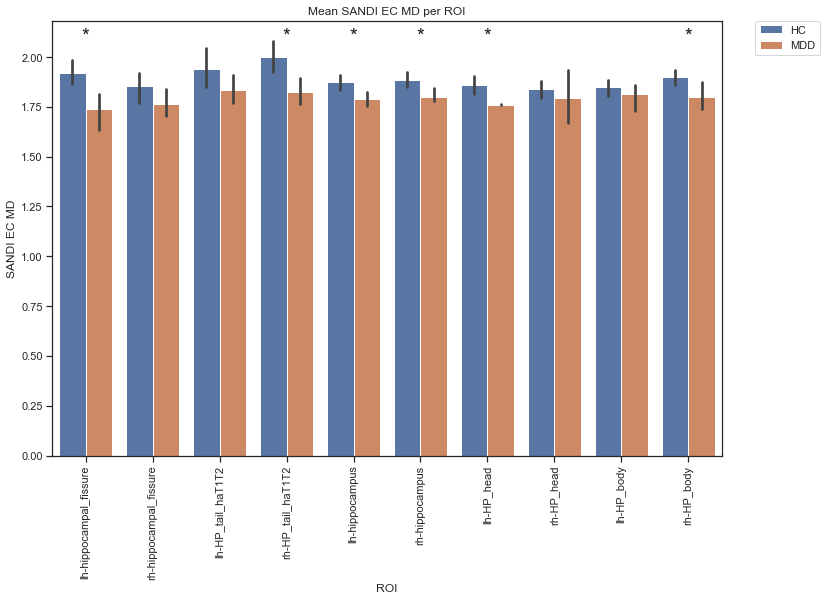

rh-hippocampal_fissure MannwhitneyuResult(statistic=1.0, pvalue=0.03681913506015133)
rh-HP_tail_haT1T2 MannwhitneyuResult(statistic=0.0, pvalue=0.018444212853524936)
lh-hippocampus MannwhitneyuResult(statistic=1.0, pvalue=0.03681913506015133)
rh-hippocampus MannwhitneyuResult(statistic=0.0, pvalue=0.018444212853524936)
lh-HP_head MannwhitneyuResult(statistic=0.0, pvalue=0.018444212853524936)


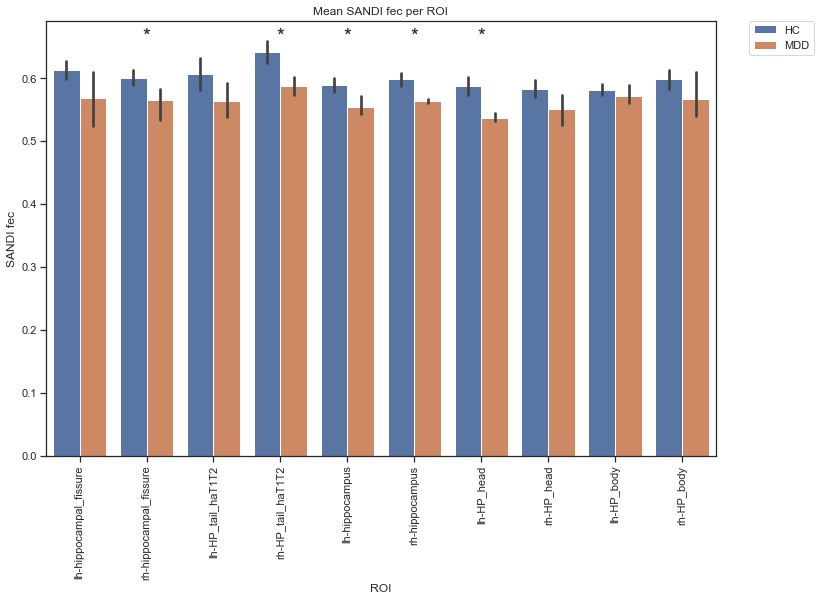

rh-HP_tail_haT1T2 MannwhitneyuResult(statistic=0.0, pvalue=0.018444212853524936)
lh-HP_head MannwhitneyuResult(statistic=1.0, pvalue=0.03681913506015133)
rh-HP_body MannwhitneyuResult(statistic=0.0, pvalue=0.018444212853524936)


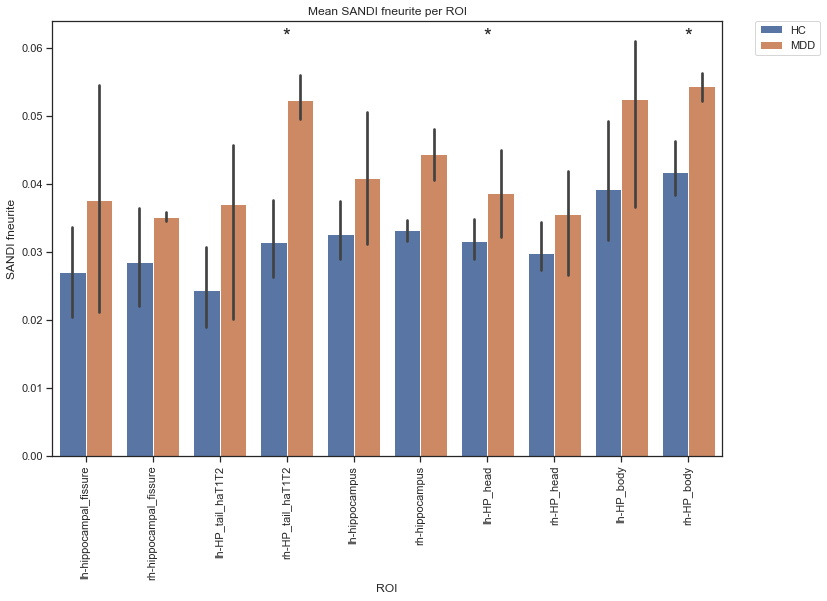

In [32]:
between_cohorts_barchart(TSPO_subfields_stats_group, TSPO_subfields_stats, chart_list, hippo_list_short)

##### Amygdala Subfields

In [33]:
print_significant_cohort(TSPO_subfields_stats, chart_list, amy_list_short)

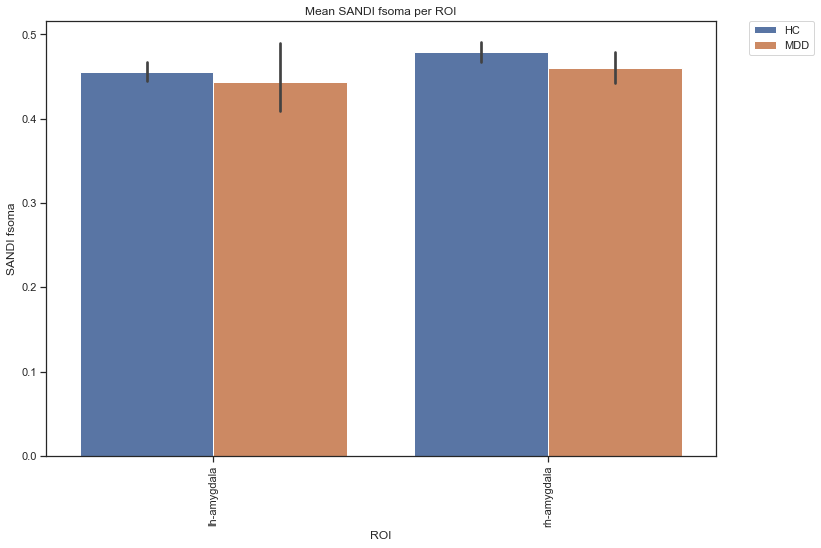

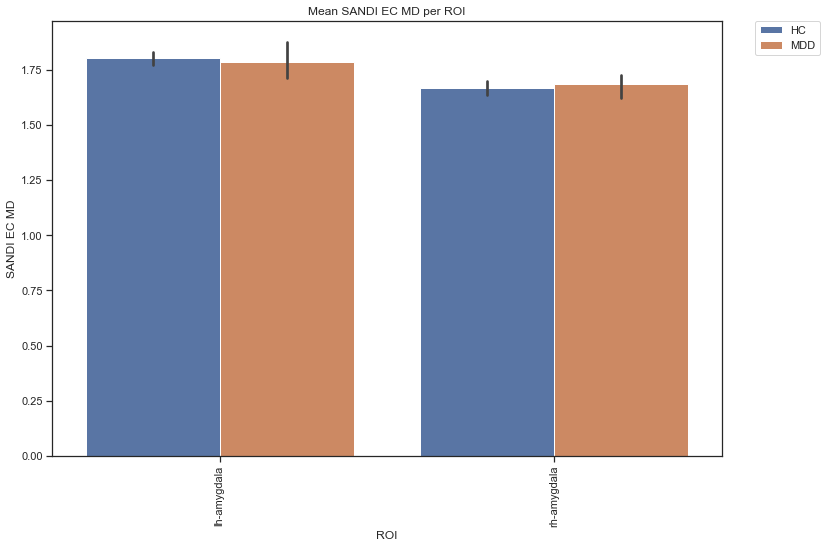

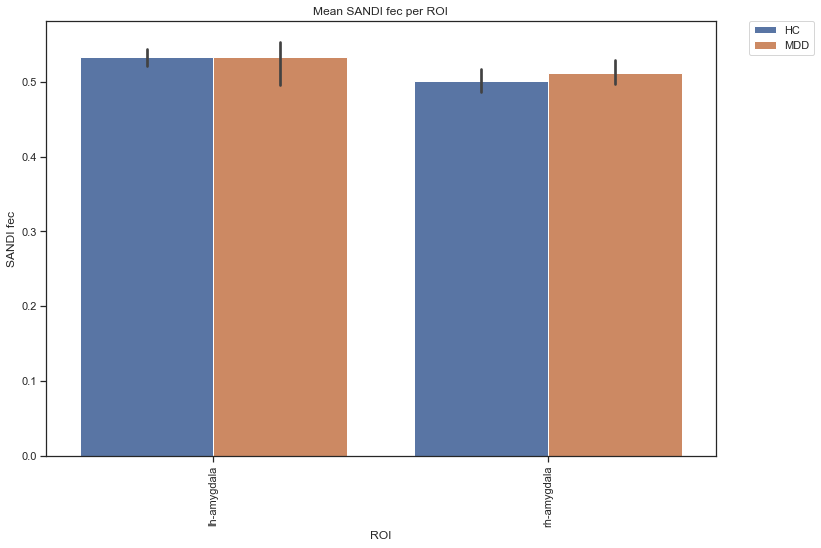

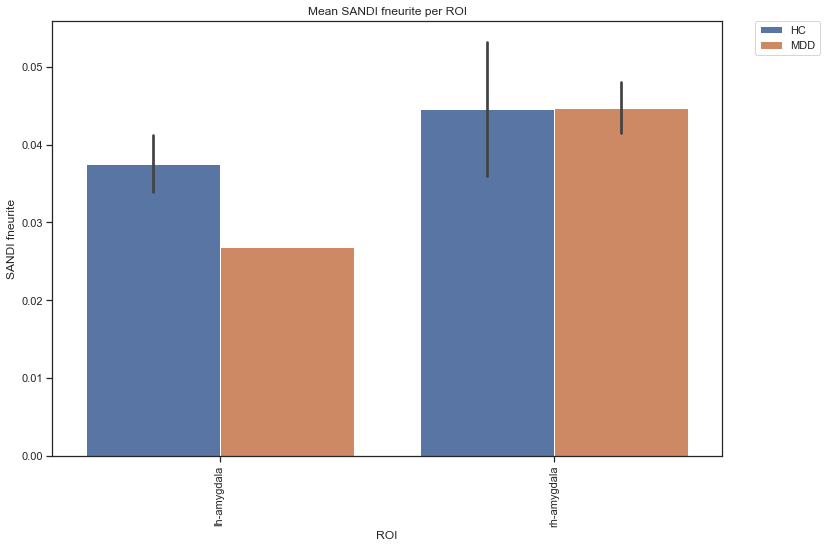

In [34]:
between_cohorts_barchart(TSPO_subfields_stats_group, TSPO_subfields_stats, chart_list, amy_list_short)

### Imaging Data vs Affect and Cognition Across All Subjects

Linear regression is for visualization purposes only.

In [35]:
def print_significance_score(TSPO_stats, param_list, roi_list, score_str):
    for param in param_list:
        mean_str = param + '_mean'
        param_df = TSPO_stats[[mean_str, 'ROI', 'subject', 'cohort']]
        x = score_str
        y= mean_str

        for roi in roi_list:
            #pull ROI rows
            param_roi = param_df[param_df['ROI'] == roi].copy()
            #add affect and cognition scores (adding now avoids duplicate data)
            param_roi = param_roi.merge(cog_affect, on=['subject', 'cohort'], how='left')
            #get rid of rows where score of interest is NA
            param_roi = param_roi[param_roi[x].notna()]
            #get rid of rows where parameter of interest equals NA
            param_roi = param_roi[param_roi[y].notna()]
            correlation, pvalue = spearmanr(param_roi[[x, y]])
            if pvalue < 0.05:
                print(param_names[param], roi)

In [36]:
def score_chart(TSPO_stats, param_list, roi_list, score_str): 
    #pull imaging parameter means from TSPO_stats
    for param in param_list:
        mean_str = param + '_mean'
        param_df = TSPO_stats[[mean_str, 'ROI', 'subject', 'cohort']]
        x = score_str
        y= mean_str

        #loop thorugh ROIs
        for roi in roi_list:
            #pull ROI rows
            param_roi = param_df[param_df['ROI'] == roi].copy()
            #add affect and cognition scores (adding now avoids duplicate data)
            param_roi = param_roi.merge(cog_affect, on=['subject', 'cohort'], how='left')
            #get rid of rows where score of interest is NA
            param_roi = param_roi[param_roi[x].notna()]
            #get rid of rows where parameter of interest equals NA
            param_roi = param_roi[param_roi[y].notna()]
            #intantiate, train, and apply a linear regression model for plotting
            lr = linear_model.LinearRegression()
            lr.fit(param_roi[[x]], param_roi[y])
            predictions = lr.predict(param_roi[[x]])
            #calculate correlations
            correlation, pvalue = spearmanr(param_roi[[x, y]])
            if pvalue < 0.05:
                #print spearmanr above chart
                print(spearmanr(param_roi[[x, y]]))
                #plot data
                sns.scatterplot(data=param_roi, x=x, y=y, hue='cohort')
                #plot linear regression
                plt.plot(param_roi[x], predictions, color='red')
                plt.title(roi)
                plt.xlabel(x)
                plt.ylabel(param_names[param])
                plt.show()
                


#### Madrs Depression Total Score

##### Large ROIs

- T1 f_W
    - ~~Hippocampus~~ not in new ROI

In [37]:
print_significance_score(TSPO_stats, chart_list, roi_list, 'madrs_score')

SANDI EC MD hippocampus
SANDI fec hippocampus
SANDI fneurite frontal


SpearmanrResult(correlation=-0.9369749612033815, pvalue=0.0018510301964418843)


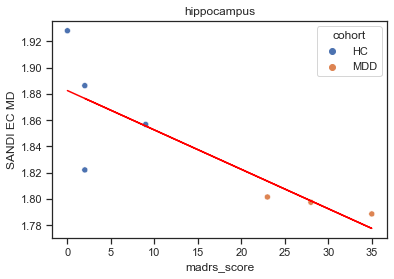

SpearmanrResult(correlation=-0.8829187134416479, pvalue=0.008450342381896611)


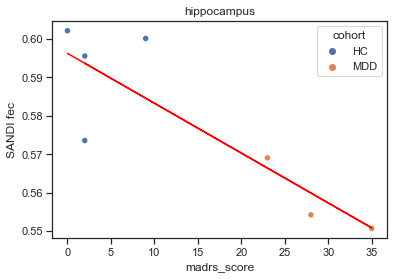

SpearmanrResult(correlation=0.8288624656799143, pvalue=0.02117351558100427)


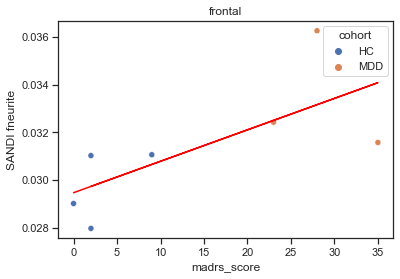

In [38]:
score_chart(TSPO_stats, chart_list, roi_list, 'madrs_score')

##### Frontal Subfields

In [39]:
print_significance_score(TSPO_subfields_stats, chart_list, frontal_list, 'madrs_score')

SANDI EC MD ctx-lh-medialorbitofrontal
SANDI fneurite lh-frontal


SpearmanrResult(correlation=-0.7567874686642697, pvalue=0.04890509913472626)


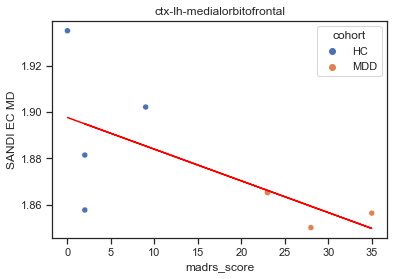

SpearmanrResult(correlation=0.7748062179181807, pvalue=0.04076946252042033)


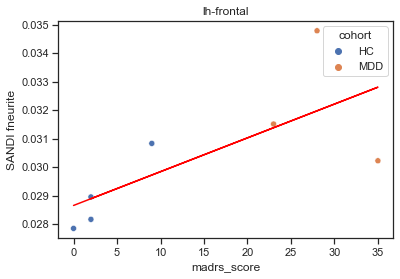

In [40]:
score_chart(TSPO_subfields_stats, chart_list, frontal_list, 'madrs_score')

##### Cingulate Subfields

In [41]:
print_significance_score(TSPO_subfields_stats, chart_list, cingulate_list, 'madrs_score')

SANDI fsoma ctx-rh-caudalanteriorcingulate
SANDI EC MD ctx-rh-caudalanteriorcingulate
SANDI fec ctx-rh-caudalanteriorcingulate


/Users/rynflaherty/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


SpearmanrResult(correlation=-0.792824967172092, pvalue=0.0334435437405415)


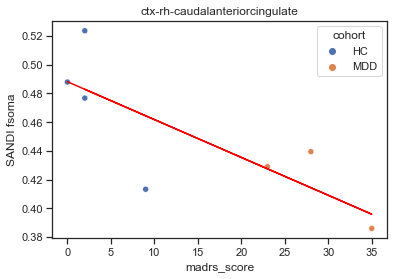

SpearmanrResult(correlation=0.8468812149338255, pvalue=0.016197127467871632)


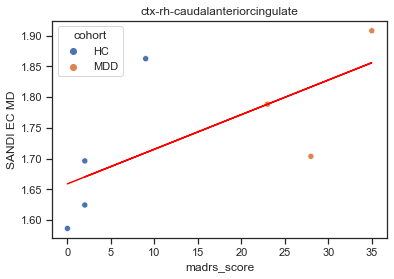

SpearmanrResult(correlation=0.792824967172092, pvalue=0.0334435437405415)


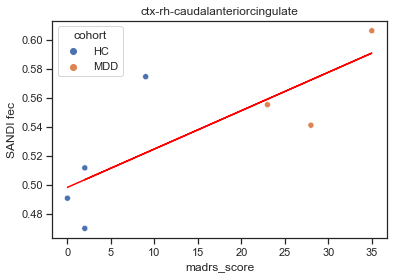

/Users/rynflaherty/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [42]:
score_chart(TSPO_subfields_stats, chart_list, cingulate_list, 'madrs_score')

##### FX Subfields

In [43]:
print_significance_score(TSPO_subfields_stats, chart_list, fx_list, 'madrs_score')

In [44]:
score_chart(TSPO_subfields_stats, chart_list, fx_list, 'madrs_score')

##### Hippocampus Subfields

In [45]:
print_significance_score(TSPO_subfields_stats, chart_list, hippo_list_short, 'madrs_score')

SANDI fsoma rh-hippocampus
SANDI fsoma rh-HP_tail_haT1T2
SANDI EC MD lh-hippocampus
SANDI EC MD lh-HP_head
SANDI EC MD lh-hippocampal_fissure
SANDI EC MD rh-HP_tail_haT1T2
SANDI fec rh-hippocampus
SANDI fec lh-HP_head
SANDI fec rh-hippocampal_fissure
SANDI fec rh-HP_tail_haT1T2
SANDI fneurite lh-HP_head
SANDI fneurite rh-HP_body
SANDI fneurite rh-HP_tail_haT1T2


SpearmanrResult(correlation=0.7748062179181807, pvalue=0.04076946252042033)


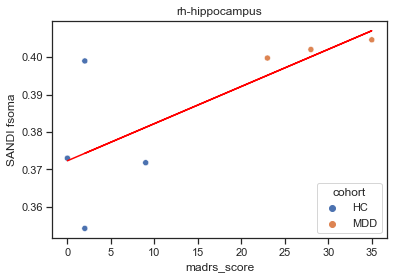

SpearmanrResult(correlation=0.7567874686642697, pvalue=0.04890509913472626)


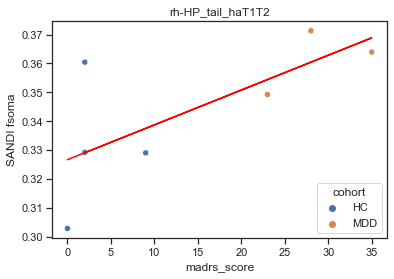

SpearmanrResult(correlation=-0.7567874686642697, pvalue=0.04890509913472626)


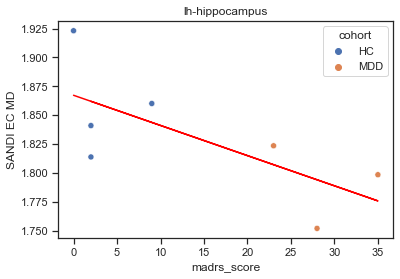

SpearmanrResult(correlation=-0.7748062179181807, pvalue=0.04076946252042033)


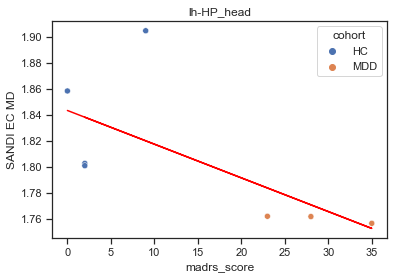

SpearmanrResult(correlation=-0.9369749612033815, pvalue=0.0018510301964418843)


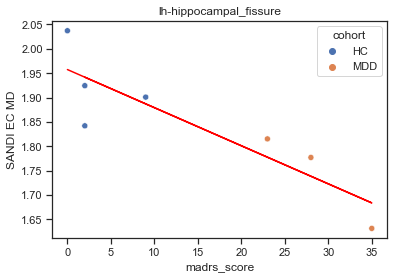

SpearmanrResult(correlation=-0.8468812149338255, pvalue=0.016197127467871632)


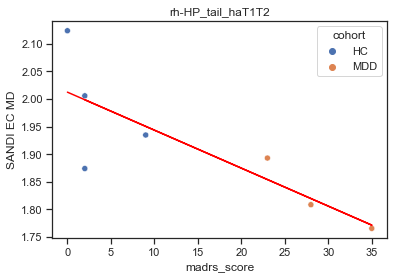

SpearmanrResult(correlation=-0.8829187134416479, pvalue=0.008450342381896611)


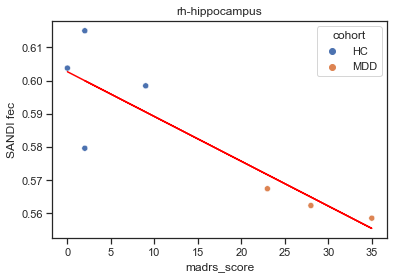

SpearmanrResult(correlation=-0.7748062179181807, pvalue=0.04076946252042033)


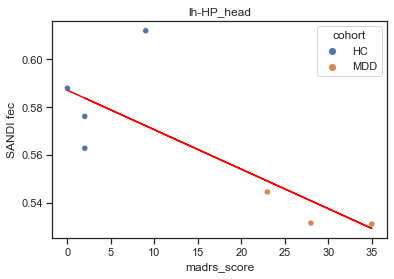

SpearmanrResult(correlation=-0.8288624656799143, pvalue=0.02117351558100427)


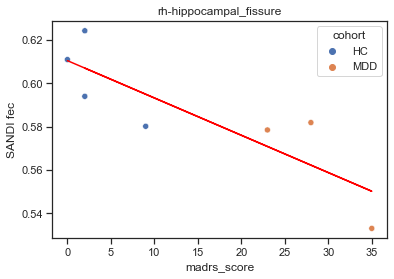

SpearmanrResult(correlation=-0.8468812149338255, pvalue=0.016197127467871632)


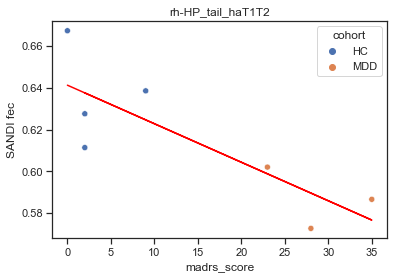

SpearmanrResult(correlation=0.8116794499134278, pvalue=0.04985758510134042)


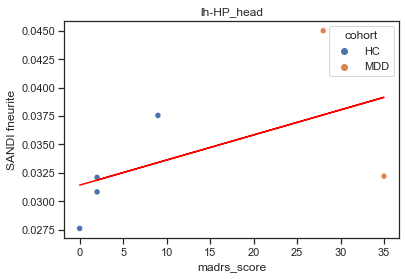

SpearmanrResult(correlation=0.792824967172092, pvalue=0.0334435437405415)


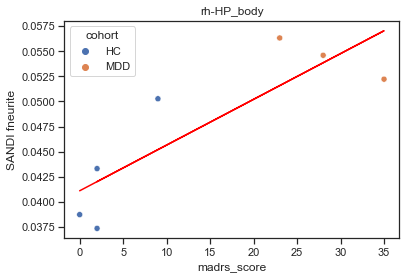

SpearmanrResult(correlation=0.7748062179181807, pvalue=0.04076946252042033)


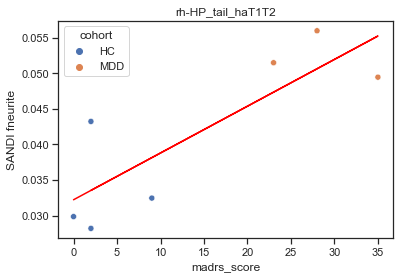

In [46]:
score_chart(TSPO_subfields_stats, chart_list, hippo_list_short, 'madrs_score')

##### Amygdala Subfields

In [47]:
print_significance_score(TSPO_subfields_stats, chart_list, amy_list_short, 'madrs_score')

SANDI fneurite lh-amygdala


#### Hama Anxiety Total Score

##### Large ROIs

- DTI FA
    - ~~Hippocampus~~ not in new ROI

In [48]:
print_significance_score(TSPO_stats, chart_list, roi_list, 'hama_totalscore')

SANDI EC MD hippocampus
SANDI fneurite frontal
SANDI fneurite hippocampus


SpearmanrResult(correlation=-0.7857142857142859, pvalue=0.03623846267982713)


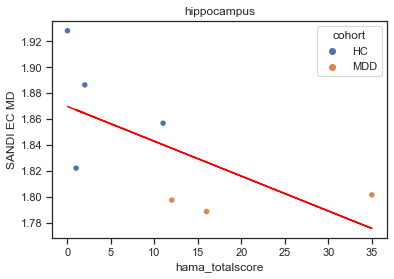

SpearmanrResult(correlation=0.7857142857142859, pvalue=0.03623846267982713)


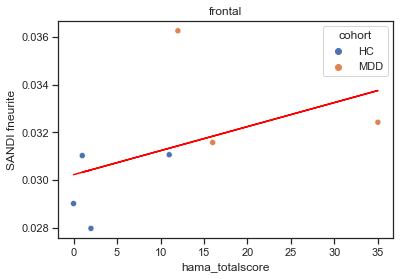

SpearmanrResult(correlation=0.8999999999999998, pvalue=0.03738607346849874)


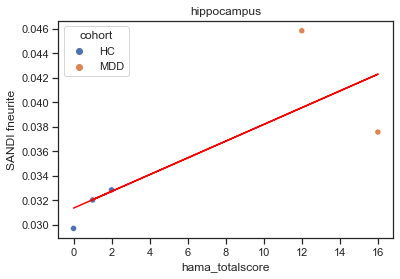

In [49]:
score_chart(TSPO_stats, chart_list, roi_list, 'hama_totalscore')

##### Cingulate Subfields

In [50]:
print_significance_score(TSPO_subfields_stats, chart_list, cingulate_list, 'hama_totalscore')

SANDI fsoma rh-cingulate
SANDI fsoma ctx-rh-caudalanteriorcingulate
SANDI fsoma ctx-rh-rostralanteriorcingulate
SANDI EC MD ctx-rh-caudalanteriorcingulate
SANDI fec rh-cingulate
SANDI fec ctx-rh-caudalanteriorcingulate
SANDI fec ctx-rh-rostralanteriorcingulate


/Users/rynflaherty/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


SpearmanrResult(correlation=-0.7857142857142859, pvalue=0.03623846267982713)


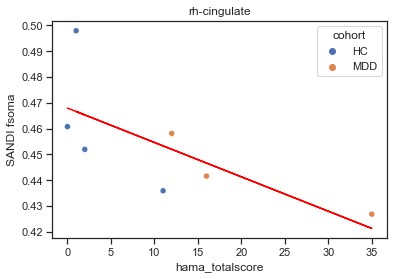

SpearmanrResult(correlation=-0.7857142857142859, pvalue=0.03623846267982713)


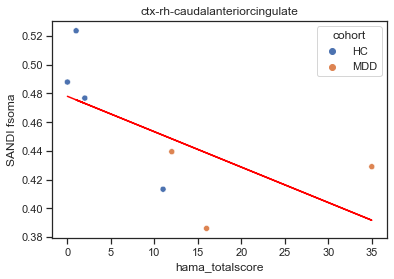

SpearmanrResult(correlation=-0.8214285714285715, pvalue=0.023448808345691505)


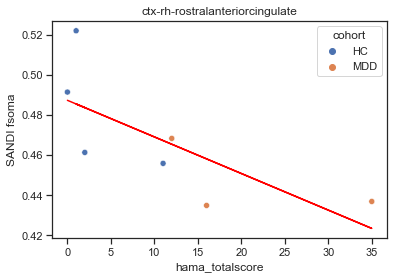

SpearmanrResult(correlation=0.8214285714285715, pvalue=0.023448808345691505)


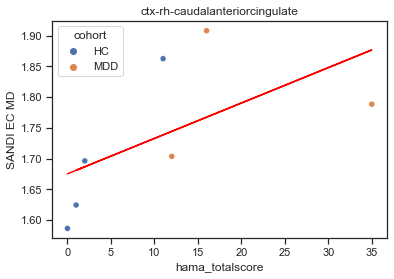

SpearmanrResult(correlation=0.7857142857142859, pvalue=0.03623846267982713)


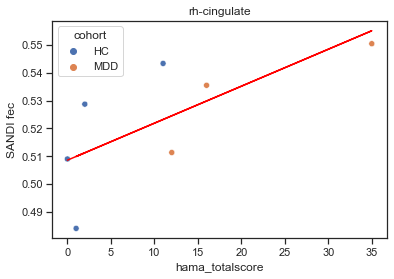

SpearmanrResult(correlation=0.7857142857142859, pvalue=0.03623846267982713)


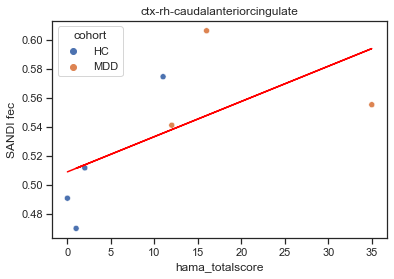

SpearmanrResult(correlation=0.8214285714285715, pvalue=0.023448808345691505)


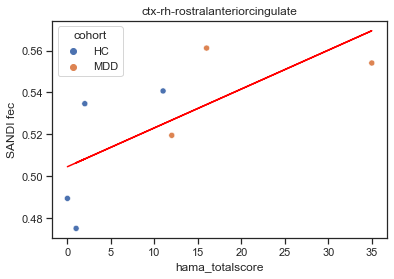

/Users/rynflaherty/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [51]:
score_chart(TSPO_subfields_stats, chart_list, cingulate_list, 'hama_totalscore')

##### FX Subfields

In [52]:
print_significance_score(TSPO_subfields_stats, chart_list, fx_list, 'hama_totalscore')

In [53]:
score_chart(TSPO_subfields_stats, chart_list, fx_list, 'hama_totalscore')

##### Frontal Subfields

In [54]:
print_significance_score(TSPO_subfields_stats, chart_list, frontal_list, 'hama_totalscore')

SANDI fneurite lh-frontal


SpearmanrResult(correlation=0.7857142857142859, pvalue=0.03623846267982713)


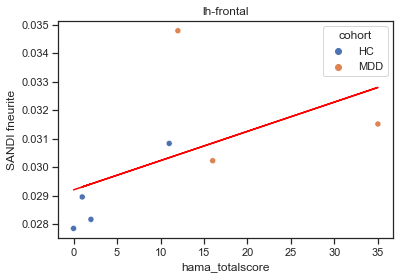

In [55]:
score_chart(TSPO_subfields_stats, chart_list, frontal_list, 'hama_totalscore')

##### Hippocampus Subfields

In [56]:
print_significance_score(TSPO_subfields_stats, chart_list, hippo_list_short, 'hama_totalscore')

SANDI EC MD lh-hippocampal_fissure
SANDI fec rh-hippocampal_fissure
SANDI fneurite rh-hippocampus
SANDI fneurite rh-HP_body
SANDI fneurite rh-HP_tail_haT1T2


SpearmanrResult(correlation=-0.8571428571428573, pvalue=0.01369732661532562)


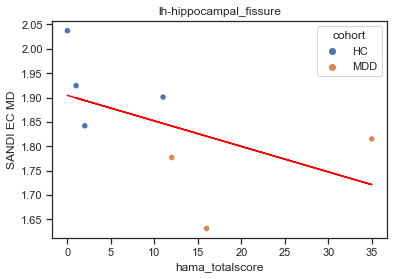

SpearmanrResult(correlation=-0.8214285714285715, pvalue=0.023448808345691505)


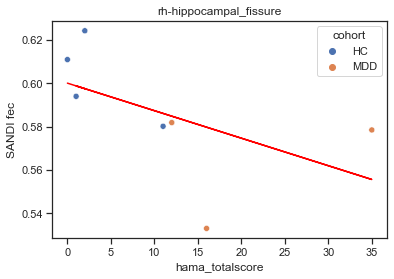

SpearmanrResult(correlation=0.942857142857143, pvalue=0.004804664723032055)


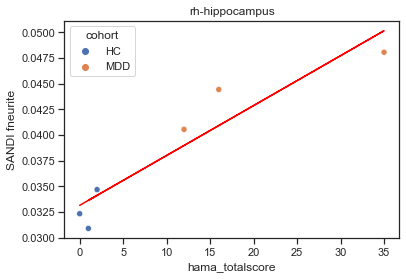

SpearmanrResult(correlation=0.9285714285714288, pvalue=0.0025194724037946874)


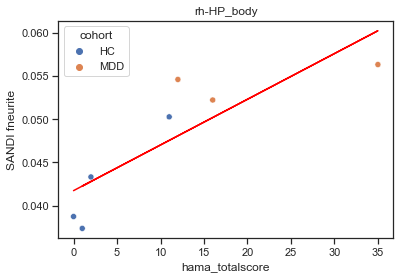

SpearmanrResult(correlation=0.8214285714285715, pvalue=0.023448808345691505)


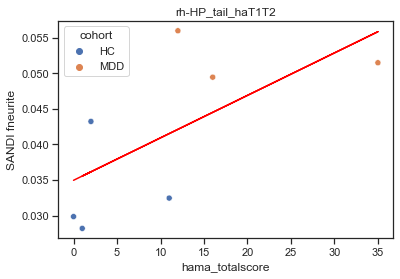

In [57]:
score_chart(TSPO_subfields_stats, chart_list, hippo_list_short, 'hama_totalscore')

##### Amygdala Subfields

In [ ]:
print_significance_score(TSPO_subfields_stats, chart_list, amy_list_short, 'hama_totalscore')

In [ ]:
score_chart(TSPO_subfields_stats, chart_list, amy_list_short, 'hama_totalscore')

#### MoCA Cognition Total Score

##### Large ROIs

In [ ]:
print_significance_score(TSPO_stats, chart_list, roi_list, 'moca_total')

In [ ]:
score_chart(TSPO_stats, chart_list, roi_list, 'moca_total')

##### Frontal Subfields

In [ ]:
print_significance_score(TSPO_subfields_stats, chart_list, frontal_list, 'moca_total')

In [ ]:
score_chart(TSPO_subfields_stats, chart_list, frontal_list, 'moca_total')

##### Cingulate Subfields

In [ ]:
print_significance_score(TSPO_subfields_stats, chart_list, cingulate_list, 'moca_total')

In [ ]:
score_chart(TSPO_subfields_stats, chart_list, cingulate_list, 'moca_total')

##### FX Subfields

In [ ]:
print_significance_score(TSPO_subfields_stats, chart_list, fx_list, 'moca_total')

##### Hippocampus Subfields

In [ ]:
print_significance_score(TSPO_subfields_stats, chart_list, hippo_list_short, 'moca_total')

In [ ]:
score_chart(TSPO_subfields_stats, chart_list, hippo_list_short, 'moca_total')

##### Amygdala Subfields

In [ ]:
print_significance_score(TSPO_subfields_stats, chart_list, amy_list_short, 'moca_total')

In [ ]:
score_chart(TSPO_subfields_stats, chart_list, amy_list_short, 'moca_total')

### Imaging Data vs Demographics Across All Subjects

Linear regression is for visualization purposes only.

In [ ]:
def print_significance_demo(TSPO_stats, param_list, roi_list, demo_str, demo):
    for param in param_list:
        mean_str = param + '_mean'
        param_df = TSPO_stats[[mean_str, 'ROI', 'subject', 'cohort']]

        for roi in roi_list:
            #pull ROI rows
            param_roi = param_df[param_df['ROI'] == roi].copy()
            x = demo_str
            y = mean_str
            #add demographic data (adding now avoids duplicate data)
            param_roi[x] = param_roi['subject'].map(demo)
            #get rid of rows where parameter of interest equals NA
            param_roi = param_roi[param_roi[y].notna()]
            correlation, pvalue = spearmanr(param_roi[[x, y]])
            if pvalue < 0.05:
                print(param_names[param], roi)


In [ ]:
#define function for imaging vs demographic charts (continuous demographic measures such as age)
def continuous_demo_chart(TSPO_stats, param_list, roi_list, demo_str, demo):
    #pull imaging parameter means from TSPO_stats
    for param in param_list:
        mean_str = param + '_mean'
        param_df = TSPO_stats[[mean_str, 'ROI', 'subject', 'cohort']]

        #loop thorugh ROIs
        for roi in roi_list:
            #pull ROI rows
            param_roi = param_df[param_df['ROI'] == roi].copy()
            x = demo_str
            y = mean_str
            #add demographic data (adding now avoids duplicate data)
            param_roi[x] = param_roi['subject'].map(demo)
            #get rid of rows where parameter of interest equals NA
            param_roi = param_roi[param_roi[y].notna()]
            #intantiate, train, and apply a linear regression model for plotting
            lr = linear_model.LinearRegression()
            lr.fit(param_roi[[x]], param_roi[y])
            predictions = lr.predict(param_roi[[x]])
            #calculate statistical significance of correlation
            correlation, pvalue = spearmanr(param_roi[[x, y]])
            #plot data
            if pvalue < 0.05:
                sns.scatterplot(data=param_roi, x=x, y=y, hue='cohort')
                #plot linear regression
                plt.plot(param_roi[x], predictions, color='red')
                plt.title(roi)
                plt.xlabel(x)
                plt.ylabel(param_names[param])
                plt.show()
                #print spearmanr under the chart
                print(spearmanr(param_roi[[x, y]]))

#### Age

##### Large ROIs

- T2 f_W 
    - Cingulate (if rounded)
- fsoma 
    - Cerebellum (if rounded) 
- T1 f_W 
    - cingulate (if rounded)

In [ ]:
print_significance_demo(TSPO_stats, chart_list, roi_list, 'age', age)

###### Frontal Subfields

In [ ]:
print_significance_demo(TSPO_subfields_stats, chart_list, frontal_list, 'age', age)

In [ ]:
continuous_demo_chart(TSPO_subfields_stats, chart_list, frontal_list, 'age', age)

###### Cingulate Subfields

In [ ]:
print_significance_demo(TSPO_subfields_stats, chart_list, cingulate_list, 'age', age)

In [ ]:
continuous_demo_chart(TSPO_subfields_stats, chart_list, cingulate_list, 'age', age)

###### FX Subfields

In [ ]:
print_significance_demo(TSPO_subfields_stats, chart_list, fx_list, 'age', age)

In [ ]:
continuous_demo_chart(TSPO_subfields_stats, chart_list, fx_list, 'age', age)

###### Hippocampus Subfields

In [ ]:
print_significance_demo(TSPO_subfields_stats, chart_list, hippo_list, 'age', age)

In [ ]:
continuous_demo_chart(TSPO_subfields_stats, chart_list, hippo_list, 'age', age)

###### Amygdala Subfields

In [ ]:
print_significance_demo(TSPO_subfields_stats, chart_list, amy_list, 'age', age)

In [ ]:
continuous_demo_chart(TSPO_subfields_stats, chart_list, amy_list, 'age', age)

###### Cerebellum Subfields

In [ ]:
print_significance_demo(TSPO_subfields_stats, chart_list, cb_list, 'age', age)

In [ ]:
continuous_demo_chart(TSPO_subfields_stats, chart_list, cb_list, 'age', age)

#### BMI

##### Large ROIs

In [ ]:
print_significance_demo(TSPO_stats, chart_list, roi_list, 'BMI', bmi)

In [ ]:
continuous_demo_chart(TSPO_stats, chart_list, roi_list, 'BMI', bmi)

##### FX Subfields

In [ ]:
print_significance_demo(TSPO_subfields_stats, chart_list, fx_list, 'BMI', bmi)

##### Frontal Subfields

In [ ]:
print_significance_demo(TSPO_subfields_stats, chart_list, frontal_list, 'BMI', bmi)

##### Hippocampus Subfields

In [ ]:
print_significance_demo(TSPO_subfields_stats, chart_list, hippo_list_short, 'BMI', bmi)

In [ ]:
print_significance_demo(TSPO_subfields_stats, chart_list, hippo_list, 'BMI', bmi)

In [ ]:
continuous_demo_chart(TSPO_subfields_stats, chart_list, hippo_list, 'BMI', bmi)

###### Amygdala Subfields

In [ ]:
print_significance_demo(TSPO_subfields_stats, chart_list, amy_list_short, 'BMI', bmi)

###### Cerebellum Subfields

In [ ]:
print_significance_demo(TSPO_subfields_stats, chart_list, cb_list, 'BMI', bmi)

In [ ]:
continuous_demo_chart(TSPO_subfields_stats, chart_list, cb_list, 'BMI', bmi)

#### Sex

In [ ]:
def print_significance_sex(TSPO_stats, param_list, roi_list):
    for param in param_list:
        mean_str = param + '_mean'
        param_df = TSPO_stats[[mean_str, 'ROI', 'subject', 'cohort']]

        #loop thorugh ROIs
        for roi in roi_list:
            #pull ROI rows
            param_roi = param_df[param_df['ROI'] == roi].copy()
            x = 'sex'
            y = mean_str
            #add demographic data (adding now avoids duplicate data)
            param_roi[x] = param_roi['subject'].map(sex)
            #get rid of rows where parameter of interest equals NA
            param_roi = param_roi[param_roi[y].notna()]
            males = param_roi[param_roi[x] == 'male'][y]
            females = param_roi[param_roi[x] == 'female'][y]
            statistic, pvalue = mannwhitneyu(males, females)
            if pvalue < 0.05:
                print(param_names[param], roi)
                

In [ ]:
def sex_chart(TSPO_stats, param_list, roi_list):
    #pull imaging parameter means from TSPO_stats
    for param in param_list:
        mean_str = param + '_mean'
        param_df = TSPO_stats[[mean_str, 'ROI', 'subject', 'cohort']]

        #loop thorugh ROIs
        for roi in roi_list:
            #pull ROI rows
            param_roi = param_df[param_df['ROI'] == roi].copy()
            x = 'sex'
            y = mean_str
            #add demographic data (adding now avoids duplicate data)
            param_roi[x] = param_roi['subject'].map(sex)
            #get rid of rows where parameter of interest equals NA
            param_roi = param_roi[param_roi[y].notna()]
            #calculate statistical significance between sexes
            males = param_roi[param_roi[x] == 'male'][y]
            females = param_roi[param_roi[x] == 'female'][y]
            statistic, pvalue = mannwhitneyu(males, females)
            if pvalue < 0.05:
                #generate category plot
                sns.catplot(x=x, y=y, data=param_roi, s=8)
                plt.title(roi)
                plt.xlabel(x)
                plt.ylabel(param_names[param])
                plt.show()

                print(mannwhitneyu(males, females))

##### Large ROIs

In [ ]:
print_significance_sex(TSPO_stats, chart_list, roi_list)

##### Frontal Subfields

In [ ]:
print_significance_sex(TSPO_subfields_stats, chart_list, frontal_list)

In [ ]:
sex_chart(TSPO_subfields_stats, chart_list, frontal_list)

##### Cingulate Subfields

In [ ]:
print_significance_sex(TSPO_subfields_stats, chart_list, cingulate_list)

In [ ]:
sex_chart(TSPO_subfields_stats, chart_list, cingulate_list)

##### FX Subfields

In [ ]:
print_significance_sex(TSPO_subfields_stats, chart_list, fx_list)

##### Hippocampus Subfields

In [ ]:
print_significance_sex(TSPO_subfields_stats, chart_list, hippo_list)

In [ ]:
sex_chart(TSPO_subfields_stats, chart_list, hippo_list)

##### Amygdala Subfields

In [ ]:
print_significance_sex(TSPO_subfields_stats, chart_list, amy_list)

In [ ]:
sex_chart(TSPO_subfields_stats, chart_list, amy_list)

###### Cerebellum subfields

In [ ]:
print_significance_sex(TSPO_subfields_stats, chart_list, cb_list)

In [ ]:
print_significance_sex(TSPO_subfields_stats, chart_list, cb_list)

## Old code and notes

#### Cohen's D analysis

In [ ]:
#initialize cohens_d_roi dataframe
cohens_d_roi = pd.DataFrame()

#loop through each roi
for roi in roi_list:
    #split each cohort into separate dataframe
    HC = TSPO_stats_group[(TSPO_stats_group['ROI'] == roi) & (TSPO_stats_group['cohort'] == 'HC')]
    MDD = TSPO_stats_group[(TSPO_stats_group['ROI'] == roi) & (TSPO_stats_group['cohort'] == 'MDD')]
    #initialize cohens_d_param (voxel-wise) and cohens_d_subject_param (subject-wise) series
    cohens_d_param = pd.Series(dtype='float64')
    cohens_d_subject_param = pd.Series(dtype='float64')

    for param in param_list:
        #pull means, voxel-wise and subject-wise standard deviations, and number of subjects per cohort
        param_mean_str = param + '_mean'
        param_std_str = param + '_std'
        param_subject_std_str = param + "_mean_subject_std"
        
        n_HC = len(TSPO_stats[(TSPO_stats['cohort'] == 'HC') & (TSPO_stats['ROI'] == roi)])
        mean_HC = float(HC[param_mean_str])
        std_HC = float(HC[param_std_str])
        std_subject_HC = float(HC[param_subject_std_str])
        
        n_MDD = len(TSPO_stats[(TSPO_stats['cohort'] == 'MDD') & (TSPO_stats['ROI'] == roi)])
        mean_MDD = float(MDD[param_mean_str])
        std_MDD = float(MDD[param_std_str])
        std_subject_MDD = float(MDD[param_subject_std_str])
        
        #calculate total number of subjects
        n_total = n_HC + n_MDD
        
        #calculate voxel-wise and subject-wise cohens d
        cohens_pooled_std = np.sqrt((((std_HC**2) * (n_HC-1)) + ((std_MDD**2) * (n_MDD-1)))/(n_total-2))
        subject_cohens_pooled_std = np.sqrt((((std_subject_HC**2) * (n_HC-1)) + ((std_subject_MDD**2) * (n_MDD-1)))/(n_total-2))
        cohens_d = (mean_MDD - mean_HC) / cohens_pooled_std
        subject_cohens_d = (mean_MDD - mean_HC) / subject_cohens_pooled_std
        
        #append calculated cohens ds to dictionaries
        cohens_d_param[param] = cohens_d
        cohens_d_subject_param[param] = subject_cohens_d
    
    #convert dictionaries to numeric dataframes
    cohens_d_param = pd.DataFrame(data=cohens_d_param).transpose().apply(pd.to_numeric)
    cohens_d_subject_param = pd.DataFrame(data=cohens_d_subject_param).transpose().apply(pd.to_numeric).add_suffix("_subject")

    #combine voxel-wise and subject-wise cohen's d dataframes into cohens_d_param
    cohens_d_param = pd.concat([cohens_d_param, cohens_d_subject_param], axis=1)
    #add column that specifies the ROI name
    cohens_d_param['ROI'] = roi
    #append cohens_d_param to cohens_d_roi and reset index
    cohens_d_roi = pd.concat([cohens_d_roi,cohens_d_param], axis=0).reset_index(drop=True)
    
cohens_d_roi


~~check amygdala hippo segmentation~~ subfields are far more accurate

grant references: DTI depression, review literature for interpreting results (start with grant references)

~~cerebellum in depression~~ Implicated, especially in vermis, reduced volume in MDD

~~cerebellum as normalization? double check, maybe pick something else~~ left occipital, myocardium, or supervised culstering

~~left occipital lobe~~ matlab code edited

~~checking T2 subfield segmentation~~

~~supervised clustering script (time permitting)~~

~~prepare slides for Monday (SUVR vs BMI, gender, weight, affect scores, reference regions?)~~
    for the most part hippocampus and amygdala pop out when you look at subfields

ISMRM diffusion MRI abstract due ~~July 20th~~ August 12th

decreased MD, increased FA, decreased RD, decreased AD. Neurons are smaller and shorter but more anisotropic? More tighly packed?
Kubicki paper shows same DTI results in patients who respond to ECT, indicating these changes may be a compensatory mechanism
Sometimes inflammation leads to decreased FA (MS), but sometimes increased FA as microglia have more organization
